In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from functional import seq
import itertools
import sys

sys.path.append("../")
from plotly_resampler.aggregation import MinMaxAggregator
from agg_utils.path_conf import figure_root_dir, loc_data_dir
from tqdm.auto import tqdm

tqdm.pandas()

from agg_utils.metrics import get_png_path
from agg_utils.conf import highlight_color


In [5]:
joined_metrics : bool = False  # set this to true if you have already joined the metrics
if not joined_metrics:
    df_m_matplotlib = pd.read_parquet(loc_data_dir / "matplotlib_metrics_v4.parquet")
    df_m_matplotlib_cairo = pd.read_parquet(
        loc_data_dir / "matplotlib_cairo_metrics_v4.parquet"
    )
    df_m_plotly = pd.read_parquet(loc_data_dir / "plotly_metrics_v4.parquet")
    df_m_plotly.aa = True
    df_m_bokeh = pd.read_parquet(loc_data_dir / "bokeh_metrics_v4.parquet")
    df_m_bokeh.aa = True
    df_m_tot = pd.concat(
        [
            df_m_bokeh,
            df_m_plotly,
            df_m_matplotlib,
            df_m_matplotlib_cairo,
        ],
        axis=0,
    ).assign(
        aggregator=lambda x: x.aggregator.astype("category"),
        ls=lambda x: x.ls.astype("category"),
        toolkit=lambda x: x.toolkit.astype("category"),
        data=lambda x: x.data.astype("category"),
    )

    df_m_tot = df_m_tot.rename(columns={"lw": "line_width", "ls": "line_shape"})
    df_m_tot["visual_cw"] = 800 / df_m_tot.line_width
    df_m_tot["visual_n_out_ratio"] = df_m_tot.n_out / (df_m_tot.visual_cw)
    df_m_tot["pixel_error_ratio_same_lw"] = (
        df_m_tot["pixel_errors_same_lw"] / df_m_tot["conv_mask_size_same_lw"]
    )
    df_m_tot["path"] = df_m_tot.apply(
        lambda x: str(get_png_path(**x.to_dict())), axis=1
    )
    df_m_tot.to_parquet("df_m_tot.parquet")
else:
    df_m_tot = pd.read_parquet("df_m_tot.parquet")
df_m_tot["line_shape"] = df_m_tot.line_shape.apply(
    lambda x: {"linear": "default", "vhv": "steps-mid"}.get(x, x)
)
cols = seq(df_m_tot.columns).filter(lambda x: "error" in x and "same_lw" in x).list()
print(cols)
out = (
    df_m_tot[cols]
    .div(df_m_tot["conv_mask_size_same_lw"], axis=0)
    .add_suffix("_ratio_cm")
)
df_m_tot[out.columns] = out
cols = seq(df_m_tot.columns).filter(lambda x: "error" in x and "ref_lw=1" in x).list()
print(cols)
out = (
    df_m_tot[cols]
    .div(df_m_tot["conv_mask_size_ref_lw=1"], axis=0)
    .add_suffix("_ratio_cm")
)
df_m_tot[out.columns] = out

del out, cols


['pixel_errors_same_lw', 'pixel_errors_margin_10_same_lw', 'pixel_errors_margin_20_same_lw', 'pixel_errors_margin_30_same_lw', 'pixel_errors_margin_50_same_lw', 'pixel_errors_margin_75_same_lw', 'pixel_errors_margin_100_same_lw', 'illumination_error_same_lw', 'illumination_error_margin_10_same_lw', 'illumination_error_margin_20_same_lw', 'pixel_error_ratio_same_lw']
['pixel_errors_ref_lw=1', 'pixel_errors_margin_10_ref_lw=1', 'pixel_errors_margin_20_ref_lw=1', 'pixel_errors_margin_30_ref_lw=1', 'pixel_errors_margin_50_ref_lw=1', 'pixel_errors_margin_75_ref_lw=1', 'pixel_errors_margin_100_ref_lw=1', 'illumination_error_ref_lw=1', 'illumination_error_margin_10_ref_lw=1', 'illumination_error_margin_20_ref_lw=1']


## Teaser figure

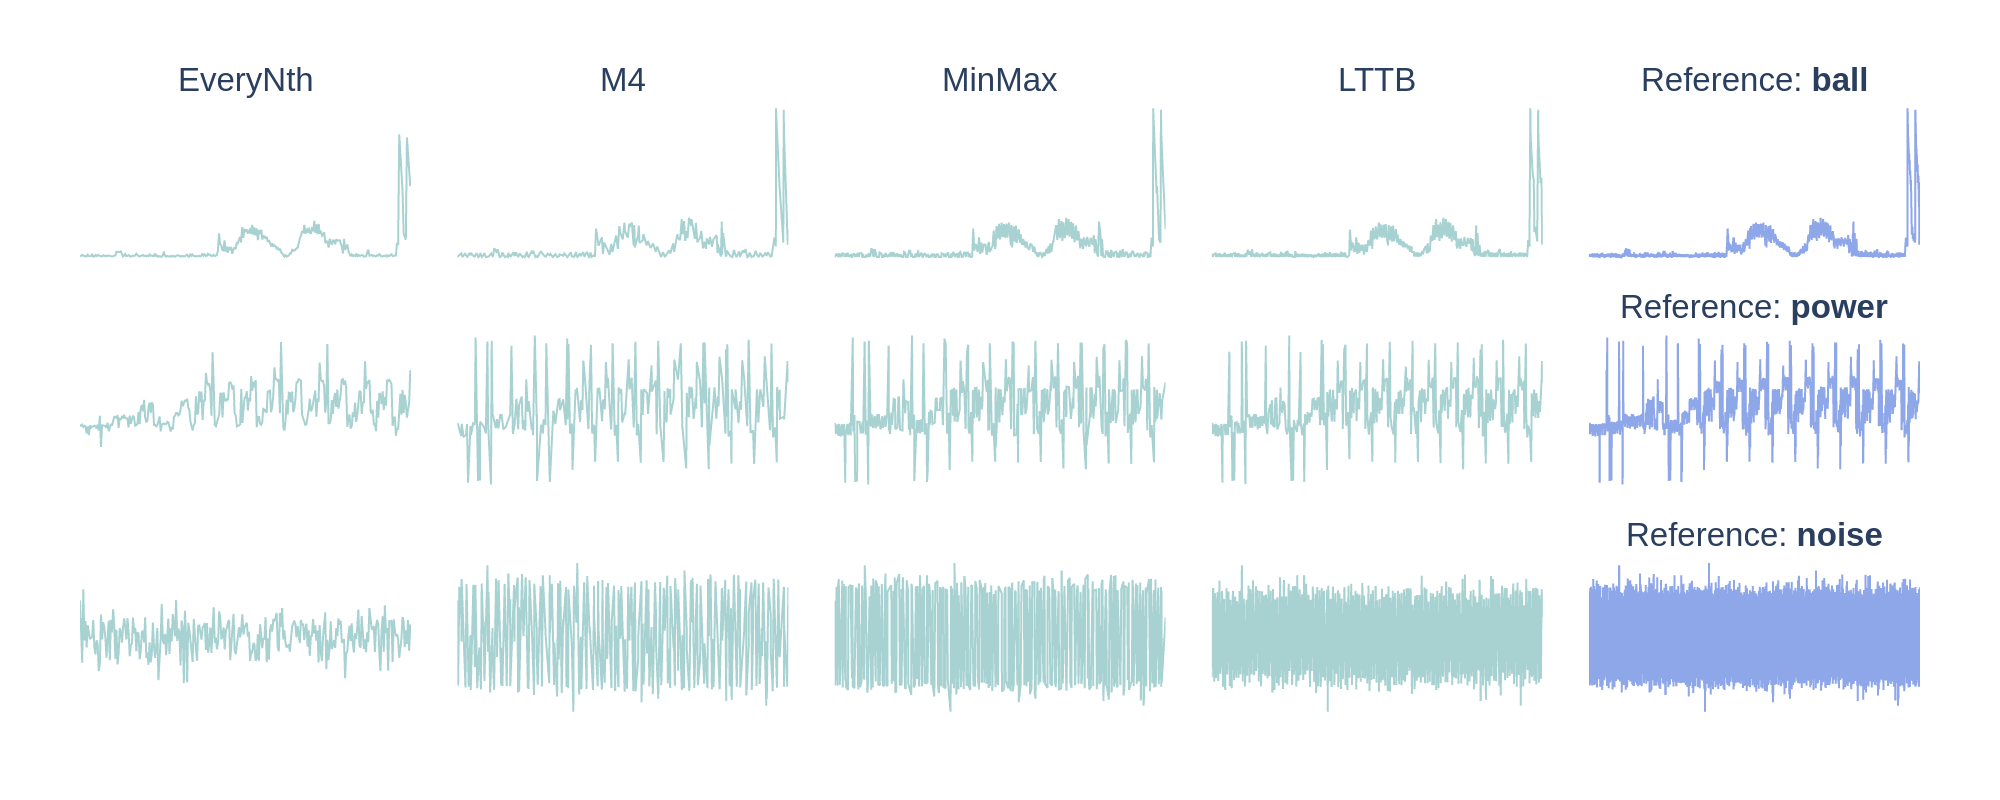

In [14]:
df_vis = df_m_tot
aggregators = [
    "EveryNthPoint",
    "M4Aggregator",
    "MinMaxAggregator",
    "LTTB",
]
n = 200_000
n_out = 300
data = ["ball", "power", "noise"]
line_shape = "default"
line_width = 2

subplot_titles = ["EveryNth", "M4", "MinMax", "LTTB"] + [f"Reference: <b>{data[0]}</b>"]
for i in range(len(data) - 1):
    subplot_titles += [""] * len(aggregators)
    subplot_titles += [f"Reference: <b>{data[i+1]}</b>"]

fig = make_subplots(
    rows=len(data),
    cols=len(aggregators) + 1,
    subplot_titles=subplot_titles,
    shared_yaxes="rows",
    shared_xaxes="rows",
    vertical_spacing=0.1,
    horizontal_spacing=0.025,
)
for row_idx, data in enumerate(data, 1):
    df_vis_n = df_vis[
        (df_vis.n == n)
        & (df_vis.n_out == n_out)
        & (df_vis.data == data)
        & (df_vis.line_shape == line_shape)
        & (df_vis.line_width == line_width)
        & (df_vis.toolkit == "matplotlib")  # doesn't matter - we just get the data
        & (df_vis.aa == False)
    ]
    for col_idx, aggregator in enumerate(aggregators, 1):
        df_vis_n_agg = df_vis_n[df_vis_n.aggregator == aggregator]
        assert len(df_vis_n_agg) == 1
        s = df_vis_n_agg.iloc[0]
        s = pd.read_parquet(
            Path(s.path).parent.parent
            / "data"
            / f"{data}_{aggregator}_{n}_{n_out}.parquet"
        )
        s = s.set_index(s.columns[0]).iloc[:, 0]
        assert len(s) <= n_out

        fig.add_trace(
            go.Scatter(
                line_width=line_width,
                line_shape={"default": "linear", "steps-mid": "vhv"}.get(line_shape),
                x=s.index,
                y=s.values,
                name=aggregator,
                showlegend=False,
                line_color="#A8D1D1", # this is the teal color
            ),
            row=row_idx,
            col=col_idx,
        )
    s = df_vis_n_agg.iloc[0]
    reference_series = pd.read_parquet(
        Path(s.path).parent.parent / "data" / f"{data}_reference_{n}.parquet"
    )
    reference_series = reference_series.set_index(reference_series.columns[0]).iloc[
        :, 0
    ]

    s_out = MinMaxAggregator()._aggregate(reference_series, 9000)
    fig.add_trace(
        go.Scatter(
            line_width=line_width,
            line_shape={"default": "linear", "steps-mid": "vhv"}.get(line_shape),
            x=s_out.index,
            y=s_out.values,
            showlegend=False,
            line_color=highlight_color,
        ),
        row=row_idx,
        col=col_idx + 1,
    )

fig.update_annotations(font_size=33)
fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_layout(template="plotly_white", height=860)
fig.show(renderer="png", width=2000, height=800)
# fig.write_html("teaser_purple.html")


## Classic visuals; `n_out` as x

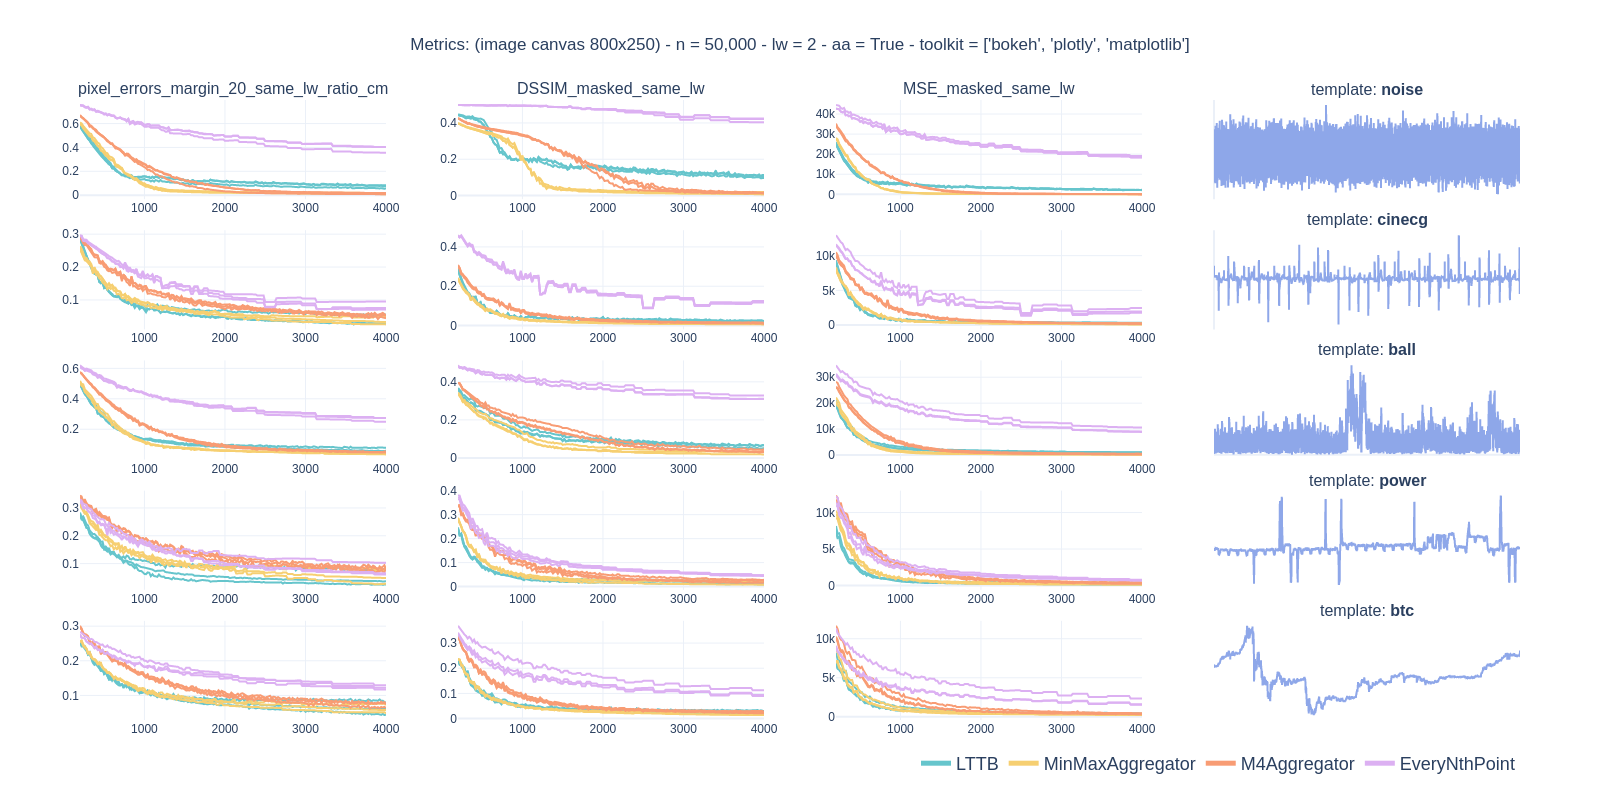

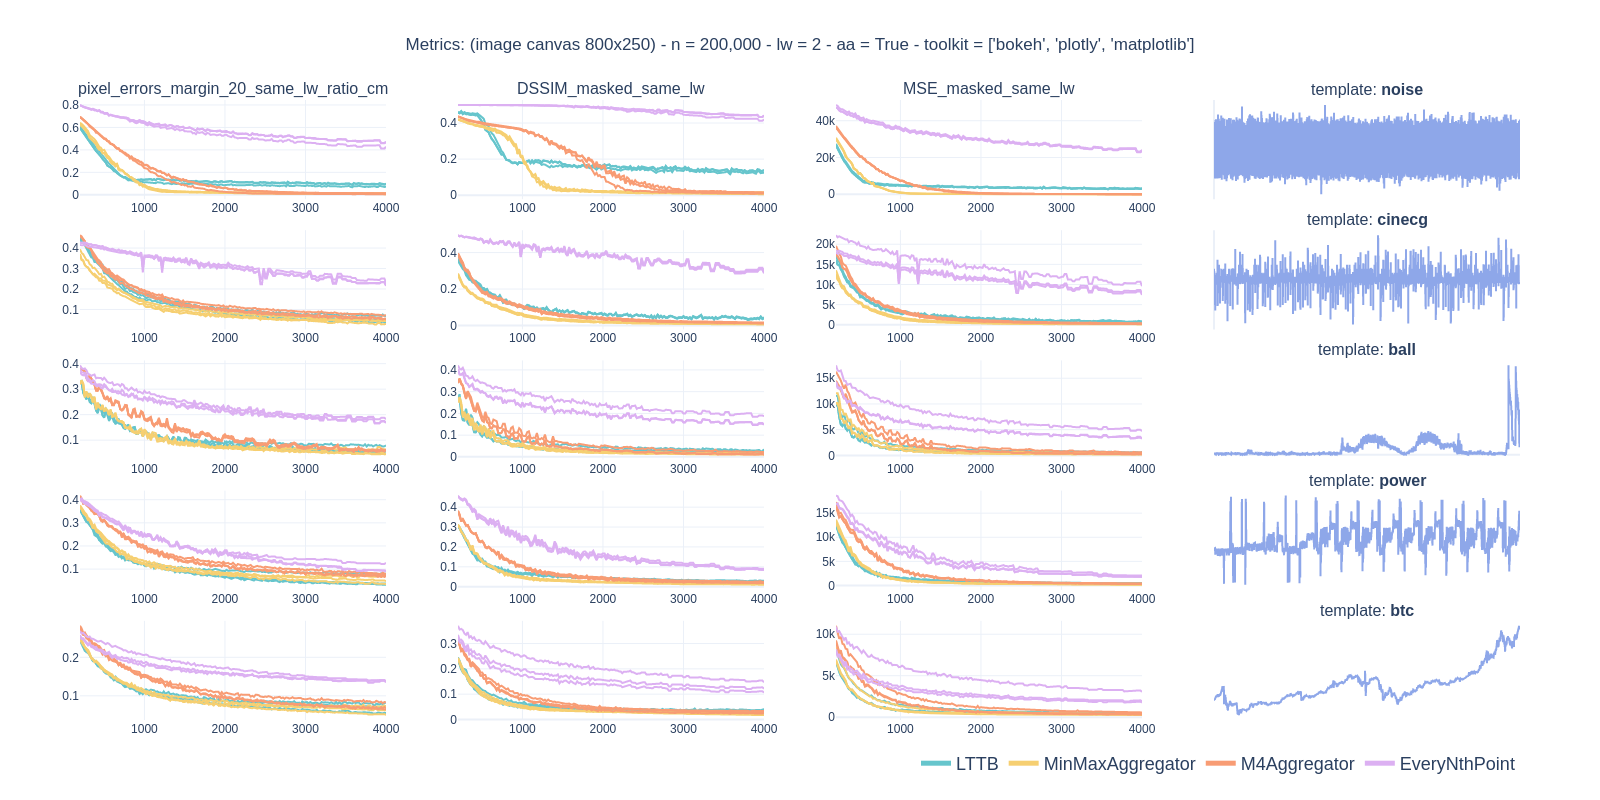

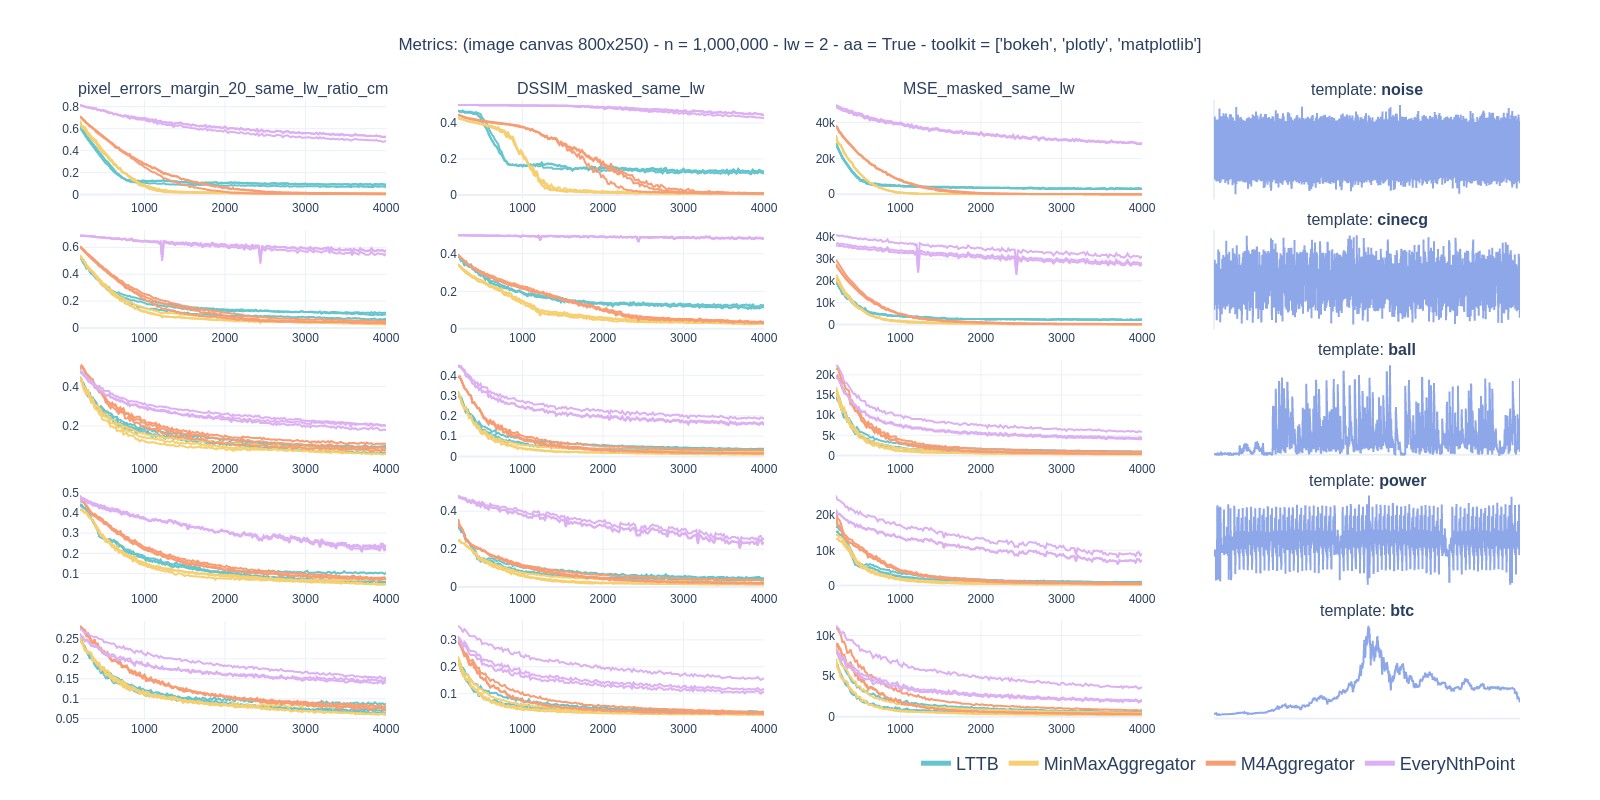

In [32]:
df_vis = df_m_tot.copy()
fig_dir = Path(df_vis["path"].iloc[0]).parent

aggregators = [ "LTTB", "MinMaxAggregator", "M4Aggregator", "EveryNthPoint" ]
metrics = [
    # "pixel_error_ratio_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    # 'pixel_errors_margin_50_same_lw_ratio_cm',
    # 'pixel_errors_margin_100_same_lw_ratio_cm',
    # 'DSSIM_same_lw',
    "DSSIM_masked_same_lw",
    # 'DSSIM_gaussian_same_lw',
    # 'DSSIM_masked_gaussian_same_lw',
    # 'MSE_same_lw',
    "MSE_masked_same_lw",
]
data_list = ['noise', 'cinecg', 'ball', 'power', 'btc']
palette = px.colors.qualitative.Pastel
antialiasing = True  # False
line_width = 2
min_n_out = 200
max_n_out = 4000
line_style = "default"
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][:3]

for n in [50_000, 200_000, 1_000_000]:
    df_vis_n = df_vis[
        (df_vis.toolkit.isin(toolkits))
        & (df_vis.n == n)
        & (df_vis.line_shape == line_style)
        & (df_vis.aa == antialiasing)
        & (df_vis.line_width == line_width)
        & (df_vis.n_out <= max_n_out)
        & (df_vis.n_out >= min_n_out)
    ].sort_values(by=["n_out", "aggregator"], ignore_index=True)
    legend_list = []

    subplot_titles = metrics + [f"template: <b>{data_list[0]}</b>"]
    for i in range(len(data_list) - 1):
        subplot_titles += [""] * len(metrics)
        subplot_titles += [f"template: <b>{data_list[i+1]}</b>"]

    fig = make_subplots(
        rows=len(data_list),
        cols=len(metrics) + 1,
        vertical_spacing=0.05,
        horizontal_spacing=0.05,
        subplot_titles=subplot_titles,
    )

    for row_idx, data_str in enumerate(data_list):
        df_vis_n_data = df_vis_n[(df_vis_n.data == data_str)]
        for col_idx, metric in enumerate(metrics):
            for color_idx, aggregator in enumerate(aggregators):
                for toolkit in df_vis_n_data.toolkit.unique():
                    # aggregate per toolkit
                    fig.add_trace(
                        go.Scatter(
                            x=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ]["n_out"],
                            y=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ][metric],
                            line_color=palette[color_idx],
                            name=aggregator,
                            showlegend=aggregator not in legend_list,
                            legendgroup=aggregator,
                            hovertext=toolkit,
                        ),
                        row=row_idx + 1,
                        col=col_idx + 1,
                    )

                    legend_list.append(aggregator)

        ref_pqt = pd.read_parquet(
            fig_dir.parent
            / "data"
            / ("_".join([data_str, "reference", str(n)]) + ".parquet")
        )
        ref_pqt = ref_pqt.set_index(ref_pqt.columns[0])
        agg_series = MinMaxAggregator().aggregate(ref_pqt[ref_pqt.columns[0]], 6000)
        fig.add_trace(
            go.Scatter(
                x=agg_series.index,
                y=agg_series,
                line_color=highlight_color,
                showlegend=False,
                line_width=line_width,
            ),
            row=row_idx + 1,
            col=len(metrics) + 1,
        )

    for col in range(1, len(metrics) + 1):
        fig.update_xaxes(title_text="n_out", row=df_vis.data.nunique(), col=col)


    fig.update_layout(
        height=900,
        template="plotly_white",
        # template="plotly_dark",
        title=f"Metrics: (image canvas 800x250) - n = {n:,} - lw = {line_width} - aa = {antialiasing} - toolkit = {toolkits}",
        title_x=0.5,
        legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            y=-0.1,
            xanchor="right",
            itemsizing="constant",
            x=1,
            font_size=18,
        ),
    )
    fig.update_xaxes(matches=None, showgrid=False, showticklabels=False, col=len(metrics) + 1)
    fig.update_yaxes(matches=None, showgrid=False, showticklabels=False, col=len(metrics) + 1)
    fig.show(renderer="png", width=1600, height=800)

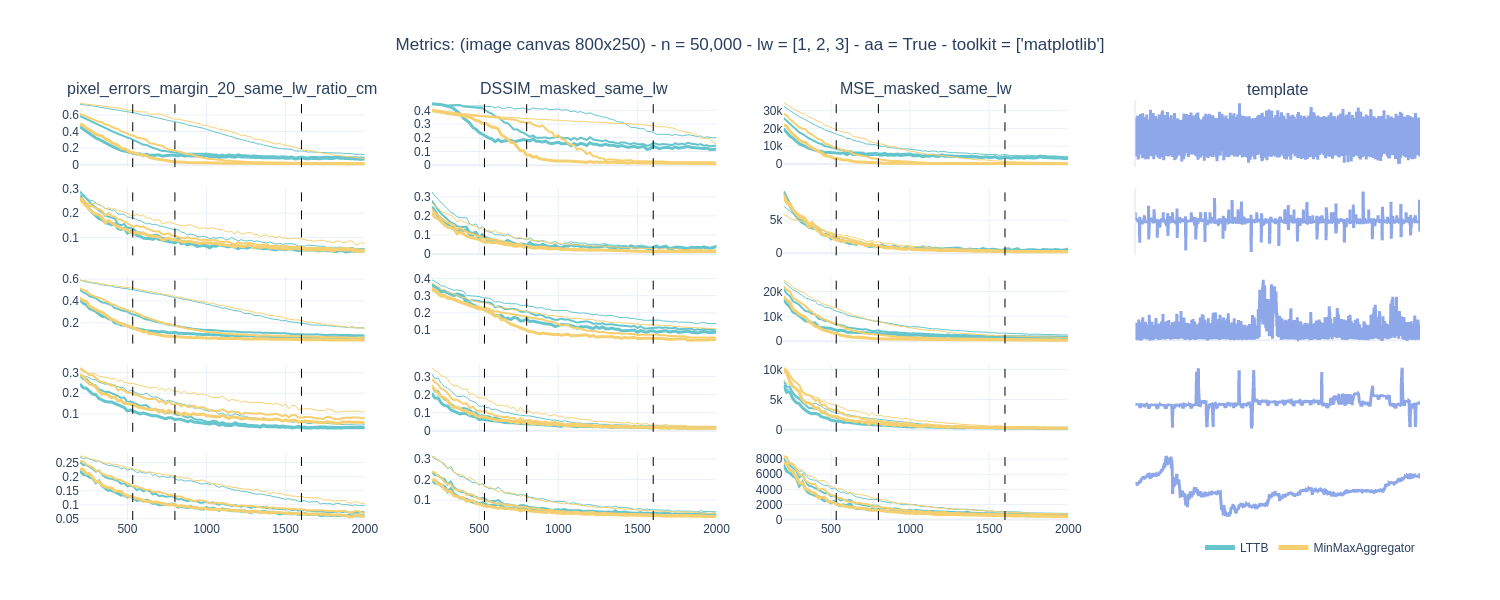

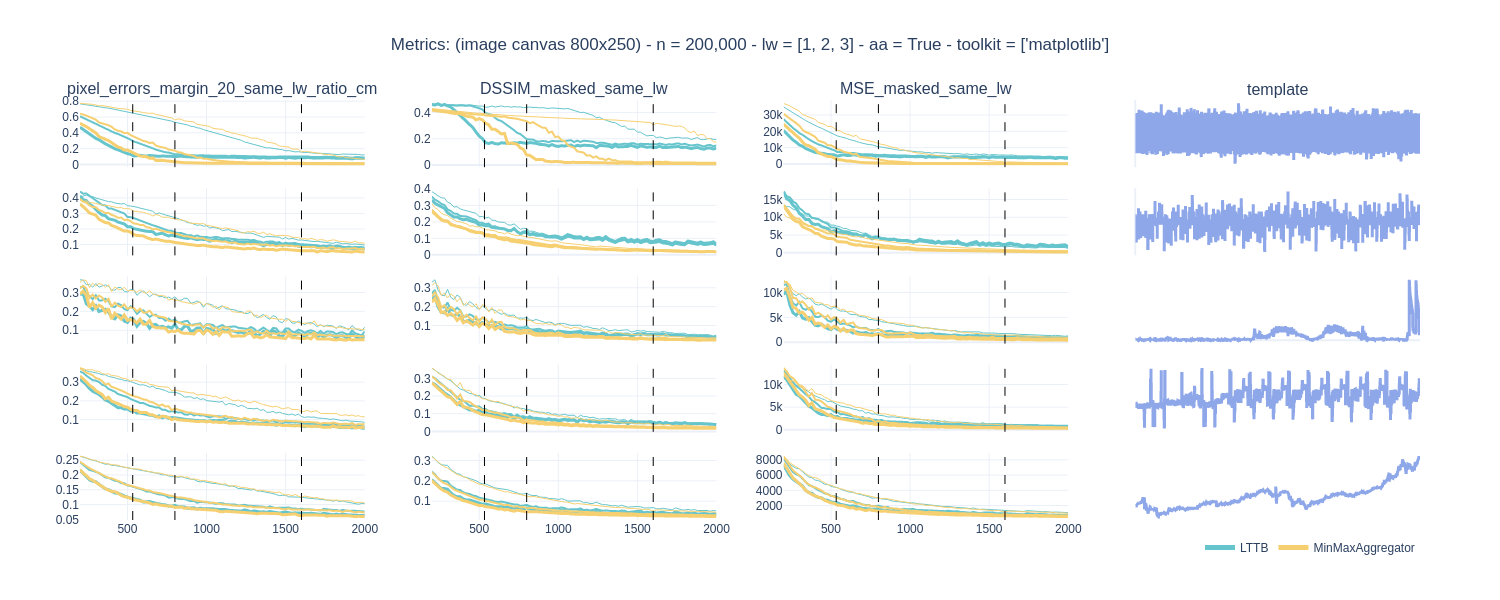

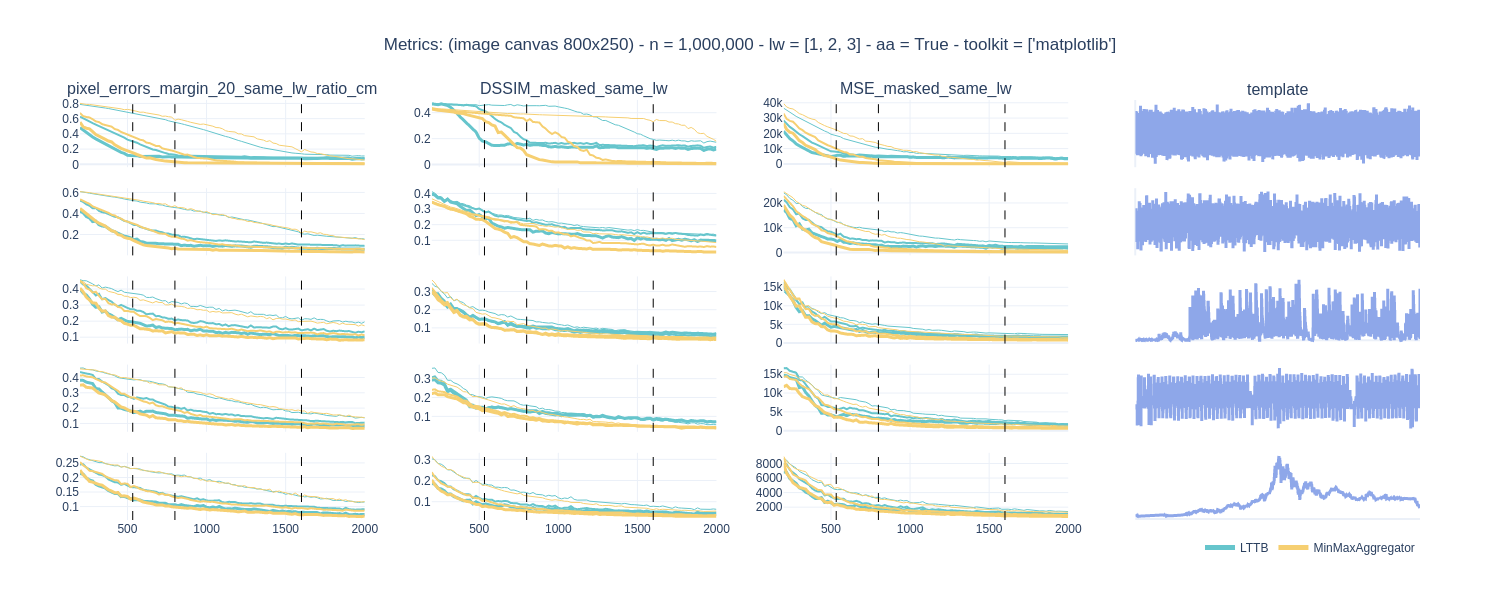

In [33]:
df_vis = df_m_tot.copy()
fig_dir = Path(df_vis["path"].iloc[0]).parent

aggregators = [ "LTTB", "MinMaxAggregator"]
metrics = [
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
    "MSE_masked_same_lw",
]

data_list = ['noise', 'cinecg', 'ball', 'power', 'btc']

palette = px.colors.qualitative.Pastel
antialiasing = True  # False
line_widths = [1, 2, 3]
min_n_out = 200
max_n_out = 2000
line_style = "default"
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][2:3]
for n in [50_000, 200_000, 1_000_000]:
    df_vis_n = df_vis[
        (df_vis.toolkit.isin(toolkits))
        & (df_vis.n == n)
        & (df_vis.line_shape == line_style)
        & (df_vis.aa == antialiasing)
        & (df_vis.line_width.isin(line_widths))
        & (df_vis.n_out <= max_n_out)
        & (df_vis.n_out >= min_n_out)
    ].sort_values(by=["n_out", "aggregator"], ignore_index=True)
    legend_list = []

    fig = make_subplots(
        rows=len(data_list),
        cols=len(metrics) + 1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        horizontal_spacing=0.05,
        subplot_titles=[*metrics, "template"],
    )

    for row_idx, data_str in enumerate(data_list):
        df_vis_n_data = df_vis_n[(df_vis_n.data == data_str)]
        for col_idx, metric in enumerate(metrics):
            for color_idx, aggregator in enumerate(aggregators):
                for toolkit in toolkits:
                    for line_width in line_widths:
                        # aggregate per toolkit
                        fig.add_trace(
                            go.Scatter(
                                x=df_vis_n_data[
                                    (df_vis_n_data.aggregator == aggregator)
                                    & (df_vis_n_data.toolkit == toolkit)
                                    & (df_vis_n_data.line_width == line_width)
                                ]["n_out"],
                                y=df_vis_n_data[
                                    (df_vis_n_data.aggregator == aggregator)
                                    & (df_vis_n_data.toolkit == toolkit)
                                    & (df_vis_n_data.line_width == line_width)
                                ][metric],
                                line_color=palette[color_idx],
                                line_width=line_width,
                                name=aggregator,
                                showlegend=aggregator not in legend_list,
                                legendgroup=aggregator,
                                hovertext=toolkit,
                            ),
                            row=row_idx + 1,
                            col=col_idx + 1,
                        )

                        legend_list.append(aggregator)

        ref_pqt = pd.read_parquet(
            fig_dir.parent
            / "data"
            / ("_".join([data_str, "reference", str(n)]) + ".parquet")
        )
        ref_pqt = ref_pqt.set_index(ref_pqt.columns[0])
        agg_series = MinMaxAggregator().aggregate(ref_pqt[ref_pqt.columns[0]], 6000)
        fig.add_trace(
            go.Scatter(
                x=agg_series.index,
                y=agg_series,
                line_color=highlight_color,
                showlegend=False,
                line_width=line_width,
            ),
            row=row_idx + 1,
            col=len(metrics) + 1,
        )

    for col in range(1, len(metrics) + 1):
        fig.update_xaxes(title_text="n_out", row=df_vis.data.nunique(), col=col)

    # fmt:off
    for i in range(len(metrics)):
        for j in range(len(data_list)):
            fig.add_vline( x=1600, line_width=1, line_dash="dash", line_color="black", col=i + 1, row=j + 1)
            fig.add_vline( x=1600 / 2, line_width=1, line_dash="dash", line_color="black", col=i + 1, row=j + 1)
            fig.add_vline( x=1600 / 3, line_width=1, line_dash="dash", line_color="black", col=i + 1, row=j + 1)

    # fmt: off
    fig.update_layout(
        height=900,
        template="plotly_white",
        title=f"Metrics: (image canvas 800x250) - n = {n:,} - lw = {line_widths} - aa = {antialiasing} - toolkit = {toolkits}",
        title_x=0.5,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.1,
            itemsizing="constant",
            xanchor="right",
            x=1,
        ),
    )
    fig.update_xaxes(matches=None, showgrid=False, showticklabels=False, col=len(metrics) + 1)
    fig.update_yaxes(matches=None, showgrid=False, showticklabels=False, col=len(metrics) + 1)
    fig.show(renderer="png", width=1500, height=600)


### Noise 

n = [50,000, 200,000, 1,000,000]  -  lw = [1, 2, 3]  -  aa = True  -  toolkit = [bokeh, plotly, matplotlib]
['MSE_masked_same_lw', 'pixel_errors_margin_20_same_lw_ratio_cm', 'DSSIM_masked_same_lw']


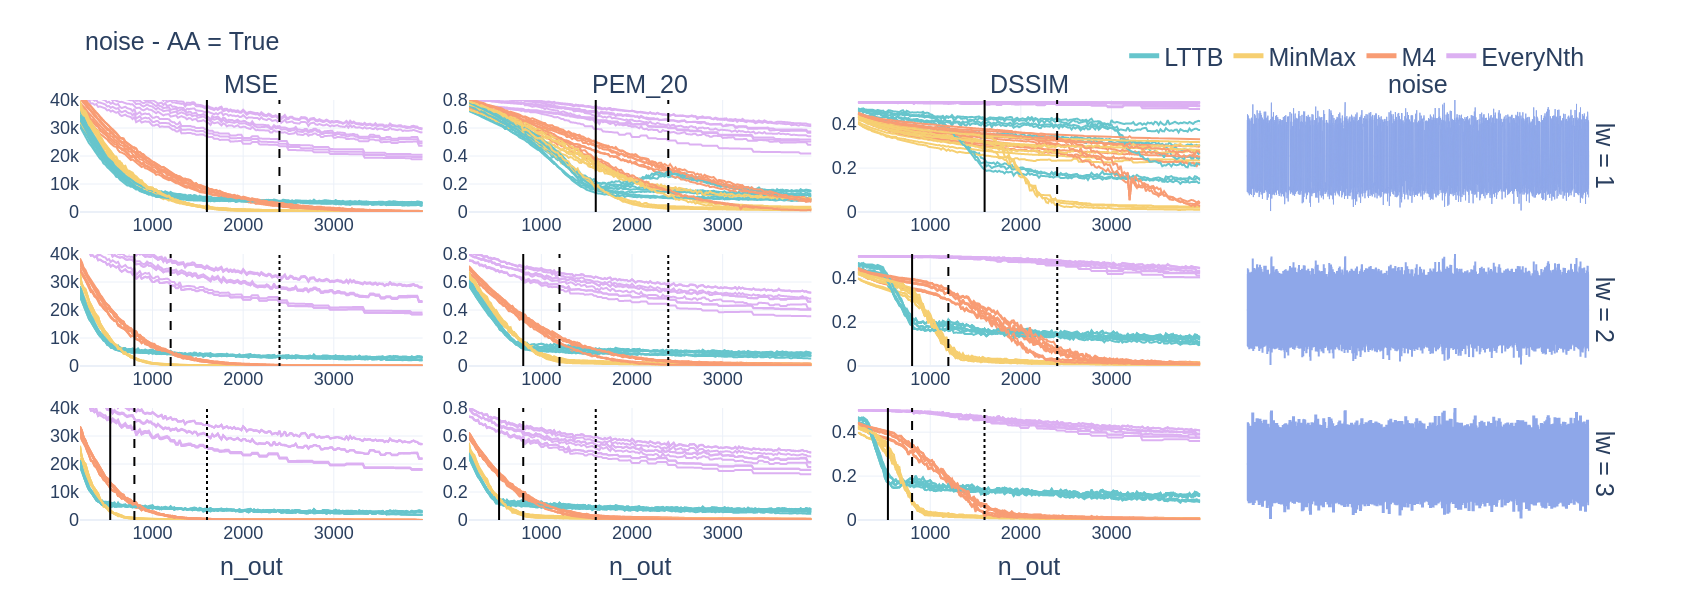

In [44]:
# AA = True
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "EveryNthPoint": "EveryNth",
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))
fig_dir = Path(df_vis["path"].iloc[0]).parent
aggregators = [ "LTTB", "MinMax", "M4", "EveryNth", ]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    # 'pixel_errors_margin_50_same_lw_ratio_cm',
    # 'pixel_errors_margin_100_same_lw_ratio_cm',
    # 'DSSIM_same_lw',
    "DSSIM_masked_same_lw",
    # 'DSSIM_gaussian_same_lw',
    # 'DSSIM_masked_gaussian_same_lw',
    # 'MSE_same_lw',
]

data_list = ["noise"]


palette = px.colors.qualitative.Pastel
antialiasing = True  # False
line_widths = [1, 2, 3]
ns = [50_000, 200_000, 1_000_000]
min_n_out = 200
max_n_out = 3990
line_style = "default"
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][:-1]
data_str = "noise"

subplot_titles = [*metrics, f"{data_str} - lw = {line_widths[0]}"]
for i in range(len(line_widths) - 1):
    subplot_titles.extend([""] * len(metrics))
    subplot_titles.append(f"{data_str} - lw = {line_widths[i + 1]}")

fig = make_subplots(
    rows=len(line_widths),
    cols=len(metrics) + 1,
    shared_xaxes="rows",
    # shared_yaxes="columns",
    vertical_spacing=0.1,
    horizontal_spacing=0.03,
    row_titles=[f"lw = {lw}" for lw in line_widths],
    column_titles=["MSE", "PEM_20", "DSSIM", "noise"],
)

font_size = 25
fig.update_annotations(font_size=font_size)
legend_list = []
for n in ns:
    df_vis_n = df_vis[
        (df_vis.toolkit.isin(toolkits))
        & (df_vis.n == n)
        & (df_vis.line_shape == line_style)
        & (df_vis.aa == antialiasing)
        & (df_vis.n_out <= max_n_out)
        & (df_vis.n_out >= min_n_out)
        & (df_vis.data == "noise")  # TODO
    ].sort_values(by=["n_out", "aggregator"], ignore_index=True)

    for row_idx, line_width in enumerate(line_widths):
        df_vis_n_data = df_vis_n[(df_vis_n.line_width == line_width)]
        for col_idx, metric in enumerate(metrics):
            for color_idx, aggregator in enumerate(aggregators):
                for toolkit in df_vis_n_data.toolkit.unique():
                    # aggregate per toolkit
                    fig.add_trace(
                        go.Scatter(
                            x=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ]["n_out"],
                            y=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ][metric],
                            line_color=palette[color_idx],
                            name=aggregator,
                            showlegend=aggregator not in legend_list,
                            legendgroup=aggregator,
                            hovertext=toolkit,
                        ),
                        row=row_idx + 1,
                        col=col_idx + 1,
                    )

                    legend_list.append(aggregator)

        if n != ns[-1]:
            continue

        ref_pqt = pd.read_parquet(
            fig_dir.parent
            / "data"
            / ("_".join([data_str, "reference", str(n)]) + ".parquet")
        )
        ref_pqt = ref_pqt.set_index(ref_pqt.columns[0])
        agg_series = MinMaxAggregator().aggregate(ref_pqt[ref_pqt.columns[0]], 6000)
        fig.add_trace(
            go.Scatter(
                x=agg_series.index,
                y=agg_series,
                line_color=highlight_color,
                showlegend=False,
                line_width=line_width,
            ),
            row=row_idx + 1,
            col=len(metrics) + 1,
        )

for col in range(1, len(metrics) + 1):
    fig.update_xaxes(
        title_text="n_out", row=len(line_widths), col=col, title_font_size=font_size
    )

# fmt: off
for i in range(len(metrics)):
    # if metric == 'MSE':
    #     continue
    for row, lw in enumerate(line_widths, 1):
        fig.add_vline( x=(800 * 2)/ lw, line_width=2, line_dash="solid", line_color="black", row=row, col=i + 1)
        fig.add_vline( x=(800 * 3)/ lw, line_width=2, line_dash="dash", line_color="black", row=row, col=i + 1)
        if lw > 1:
            fig.add_vline( x=(800 * 3  * 2)/ lw, line_width=2, line_dash="dot", line_color="black", row=row, col=i + 1)

fig.update_yaxes(showticklabels=False, col=len(metrics) + 1)
fig.update_xaxes(showticklabels=False, visible=False, col=len(metrics) + 1)
# update the font size of axis ticks
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)

# update the range of the y-axes
fig.update_yaxes(range=[0, 40000], col=1)
fig.update_yaxes(range=[0.00, 0.8], col=2)
fig.update_yaxes(range=[0.00, 0.51], col=3)
fig.update_yaxes(range=[-5, 5], col=4)

n_strs = [f"{n:,}" for n in ns]
print(
    f"n = {n_strs}  -  lw = {line_widths}  -  aa = {antialiasing}  -  toolkit = {toolkits}".replace(
        "'", ""
    )
)
print(metrics)
fig.update_layout(
    height=620,
    template="plotly_white",
    # template="plotly_dark",
    title_x=0.5,
    # put the legend at the bottom right
    # font_size=16,
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        itemsizing="constant",
        x=0.98,
        font_size=font_size,
    ),
    title='noise - AA = True',
    title_font_size=font_size,
)
fig.update_xaxes(matches=None, showticklabels=True, col=len(metrics) + 1)
fig.show(renderer="png", width=1700, height=600)

n = [50,000, 200,000, 1,000,000]  -  lw = [1, 2, 3]  -  aa = False  -  toolkit = [bokeh, plotly, matplotlib, matplotlib_cairo]
['MSE_masked_same_lw', 'pixel_errors_margin_20_same_lw_ratio_cm', 'DSSIM_masked_same_lw']


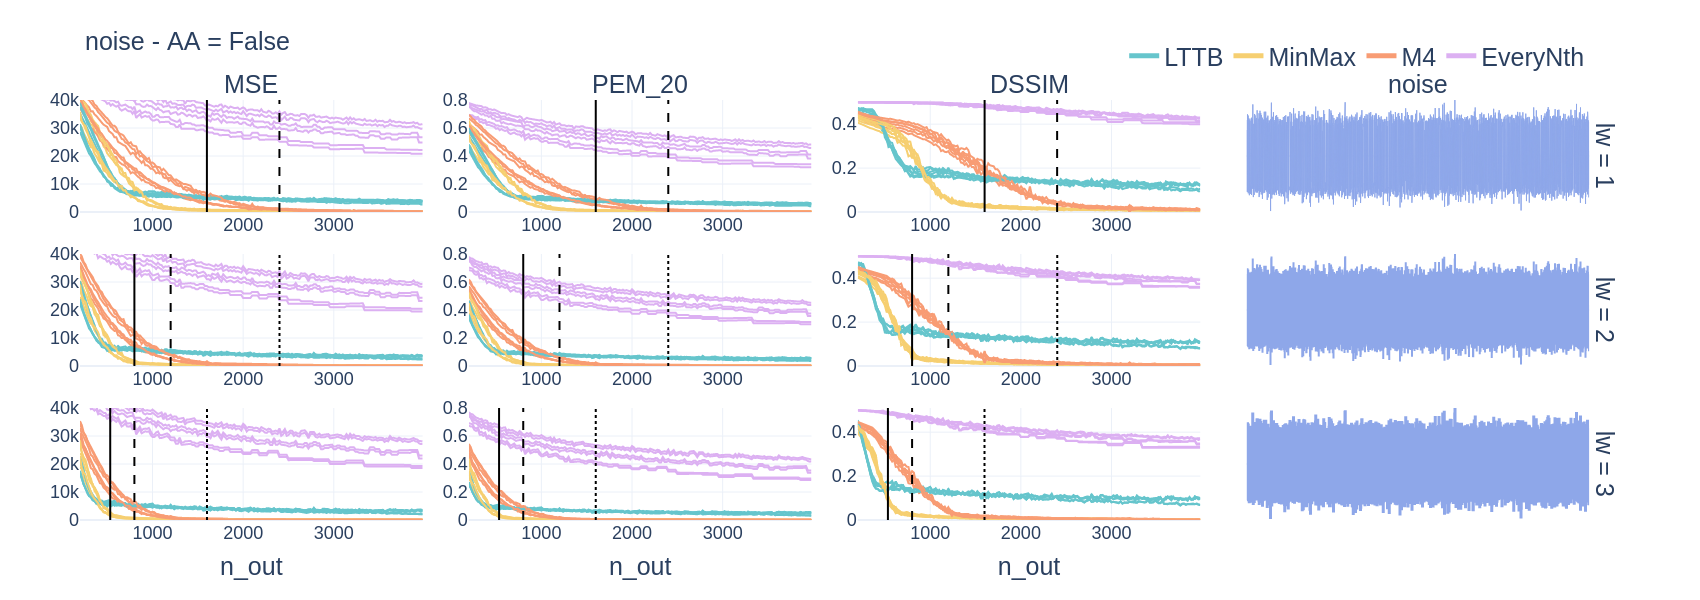

In [47]:
# AA = False
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "EveryNthPoint": "EveryNth",
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))
fig_dir = Path(df_vis["path"].iloc[0]).parent
aggregators = [ "LTTB", "MinMax", "M4", "EveryNth" ]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    # 'pixel_errors_margin_50_same_lw_ratio_cm',
    # 'pixel_errors_margin_100_same_lw_ratio_cm',
    # 'DSSIM_same_lw',
    "DSSIM_masked_same_lw",
    # 'DSSIM_gaussian_same_lw',
    # 'DSSIM_masked_gaussian_same_lw',
    # 'MSE_same_lw',
]

data_list = ["noise"]


palette = px.colors.qualitative.Pastel
antialiasing = False
line_widths = [1, 2, 3]
ns = [50_000, 200_000, 1_000_000]
min_n_out = 200
max_n_out = 3990
line_style = "default"
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][:]
data_str = "noise"

subplot_titles = [*metrics, f"{data_str} - lw = {line_widths[0]}"]
for i in range(len(line_widths) - 1):
    subplot_titles.extend([""] * len(metrics))
    subplot_titles.append(f"{data_str} - lw = {line_widths[i + 1]}")

fig = make_subplots(
    rows=len(line_widths),
    cols=len(metrics) + 1,
    shared_xaxes="rows",
    # shared_yaxes="columns",
    vertical_spacing=0.1,
    horizontal_spacing=0.03,
    row_titles=[f"lw = {lw}" for lw in line_widths],
    column_titles=["MSE", "PEM_20", "DSSIM", "noise"],
)

font_size = 25
fig.update_annotations(font_size=font_size)
legend_list = []
for n in ns:
    df_vis_n = df_vis[
        (df_vis.toolkit.isin(toolkits))
        & (df_vis.n == n)
        & (df_vis.line_shape == line_style)
        & (df_vis.aa == antialiasing)
        & (df_vis.n_out <= max_n_out)
        & (df_vis.n_out >= min_n_out)
        & (df_vis.data == "noise") 
    ].sort_values(by=["n_out", "aggregator"], ignore_index=True)

    for row_idx, line_width in enumerate(line_widths):
        df_vis_n_data = df_vis_n[(df_vis_n.line_width == line_width)]
        for col_idx, metric in enumerate(metrics):
            for color_idx, aggregator in enumerate(aggregators):
                for toolkit in df_vis_n_data.toolkit.unique():
                    # aggregate per toolkit
                    fig.add_trace(
                        go.Scatter(
                            x=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ]["n_out"],
                            y=df_vis_n_data[
                                (df_vis_n_data.aggregator == aggregator)
                                & (df_vis_n_data.toolkit == toolkit)
                            ][metric],
                            line_color=palette[color_idx],
                            name=aggregator,
                            showlegend=aggregator not in legend_list,
                            legendgroup=aggregator,
                            hovertext=toolkit,
                        ),
                        row=row_idx + 1,
                        col=col_idx + 1,
                    )

                    legend_list.append(aggregator)

        if n != ns[-1]:
            continue

        ref_pqt = pd.read_parquet(
            fig_dir.parent
            / "data"
            / ("_".join([data_str, "reference", str(n)]) + ".parquet")
        )
        ref_pqt = ref_pqt.set_index(ref_pqt.columns[0])
        agg_series = MinMaxAggregator().aggregate(ref_pqt[ref_pqt.columns[0]], 6000)
        fig.add_trace(
            go.Scatter(
                x=agg_series.index,
                y=agg_series,
                line_color=highlight_color,
                showlegend=False,
                line_width=line_width,
            ),
            row=row_idx + 1,
            col=len(metrics) + 1,
        )

for col in range(1, len(metrics) + 1):
    fig.update_xaxes(
        title_text="n_out", row=len(line_widths), col=col, title_font_size=font_size
    )

# fmt: off
for i in range(len(metrics)):
    # if metric == 'MSE':
    #     continue
    for row, lw in enumerate(line_widths, 1):
        fig.add_vline( x=(800 * 2)/ lw, line_width=2, line_dash="solid", line_color="black", row=row, col=i + 1)
        fig.add_vline( x=(800 * 3)/ lw, line_width=2, line_dash="dash", line_color="black", row=row, col=i + 1)
        if lw > 1:
            fig.add_vline( x=(800 * 3  * 2)/ lw, line_width=2, line_dash="dot", line_color="black", row=row, col=i + 1)

fig.update_yaxes(showticklabels=False, col=len(metrics) + 1)
fig.update_xaxes(showticklabels=False, visible=False, col=len(metrics) + 1)
# update the font size of axis ticks
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)

# update the range of the y-axes
fig.update_yaxes(range=[0, 40000], col=1)
fig.update_yaxes(range=[0.00, 0.8], col=2)
fig.update_yaxes(range=[0.00, 0.51], col=3)
fig.update_yaxes(range=[-5, 5], col=4)

n_strs = [f"{n:,}" for n in ns]
print(
    f"n = {n_strs}  -  lw = {line_widths}  -  aa = {antialiasing}  -  toolkit = {toolkits}".replace(
        "'", ""
    )
)
print(metrics)
fig.update_layout(
    height=620,
    template="plotly_white",
    # template="plotly_dark",
    title_x=0.5,
    # put the legend at the bottom right
    # font_size=16,
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        itemsizing="constant",
        x=0.98,
        font_size=font_size,
    ),
    title='noise - AA = False',
    title_font_size=font_size,
)
fig.update_xaxes(matches=None, showticklabels=True, col=len(metrics) + 1)
fig.show(renderer="png", width=1700, height=600)

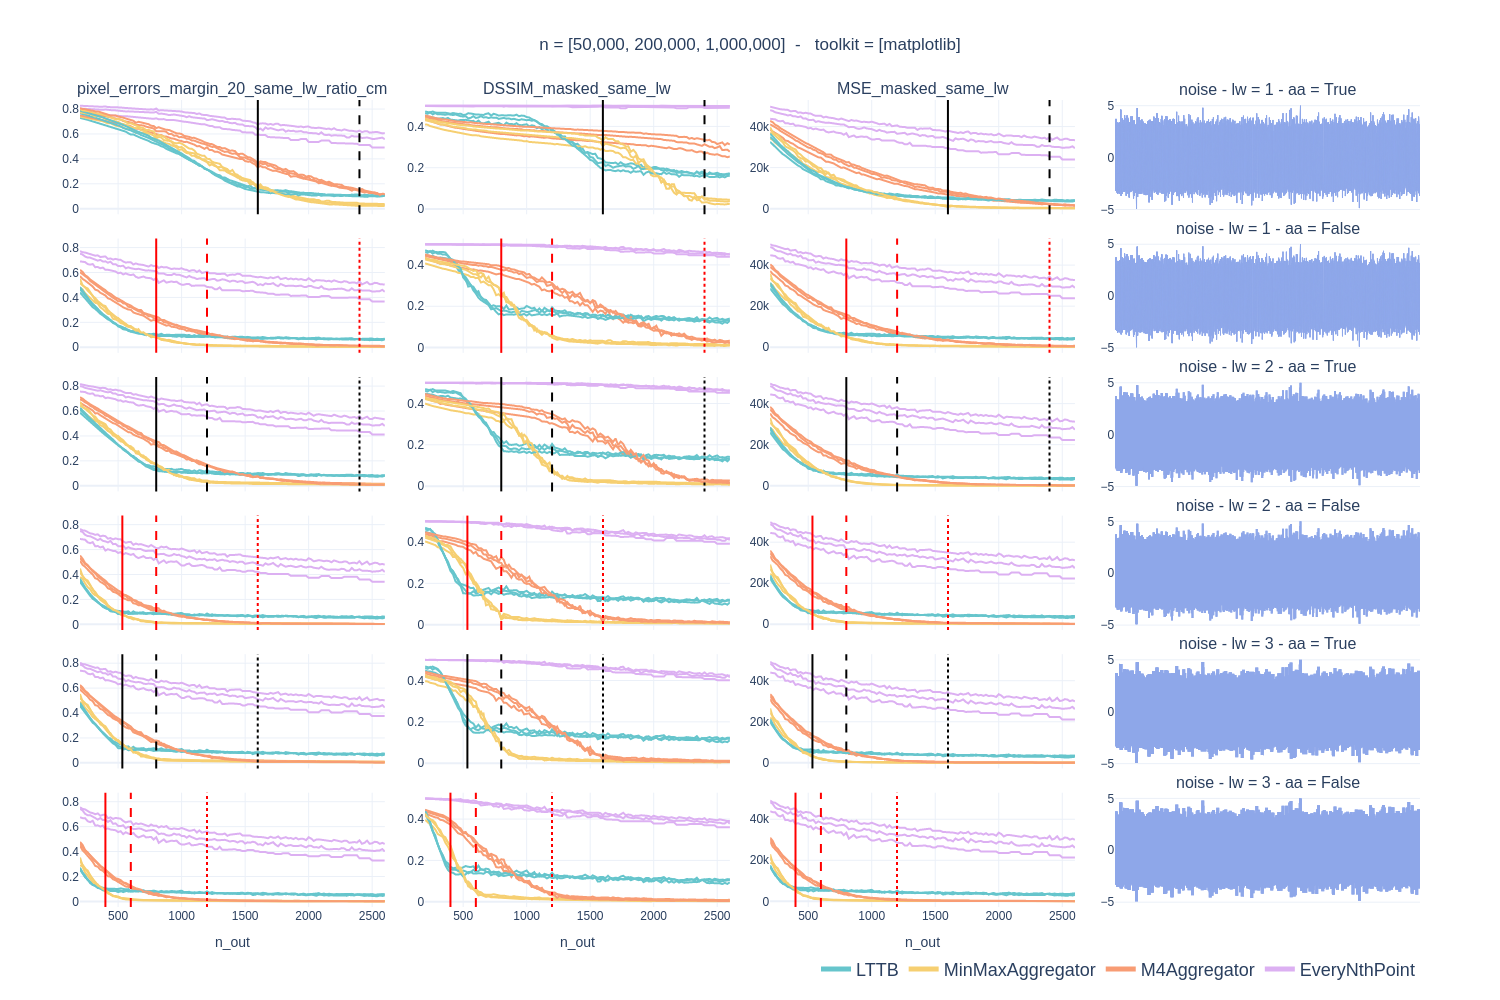

In [64]:
# AA true and false for a single line width
df_vis = df_m_tot.copy()
fig_dir = Path(df_vis["path"].iloc[0]).parent

aggregators = [
    "LTTB",
    "MinMaxAggregator",
    "M4Aggregator",
    "EveryNthPoint",
]
metrics = [
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
    "MSE_masked_same_lw",
]
data_list = ["noise"]
palette = px.colors.qualitative.Pastel
line_widths = [1, 2, 3][:3]
ns = [50_000, 200_000, 1_000_000][:]
min_n_out = 200
max_n_out = 2600
line_style = "default"
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][-2:-1]
data_str = data_list[0]

subplot_titles = [*metrics, f"{data_str} - lw = {line_widths[0]} - aa = True"]
subplot_titles.extend([""] * len(metrics))
subplot_titles.append(f"{data_str} - lw = {line_widths[0]} - aa = False")
for i in range(len(line_widths) - 1):
    subplot_titles.extend([""] * len(metrics))
    subplot_titles.append(f"{data_str} - lw = {line_widths[i + 1]} - aa = True")
    subplot_titles.extend([""] * len(metrics))
    subplot_titles.append(f"{data_str} - lw = {line_widths[i + 1]} - aa = False")

fig = make_subplots(
    rows=len(line_widths) * 2,
    cols=len(metrics) + 1,
    shared_xaxes="columns",
    shared_yaxes="columns",
    vertical_spacing=0.03,
    horizontal_spacing=0.03,
    subplot_titles=subplot_titles,
)

legend_list = []
for n in ns:
    for antialiasing in [False, True]:
        df_vis_n = df_vis[
            (df_vis.toolkit.isin(toolkits))
            & (df_vis.n == n)
            & (df_vis.line_shape == line_style)
            & (df_vis.aa == antialiasing)
            & (df_vis.n_out <= max_n_out)
            & (df_vis.n_out >= min_n_out)
            & (df_vis.data.isin(data_list))
        ].sort_values(by=["n_out", "aggregator"], ignore_index=True)

        for row_idx, line_width in enumerate(line_widths):
            row_idx = 2 * row_idx + int(not antialiasing)
            df_vis_n_data = df_vis_n[(df_vis_n.line_width == line_width)]
            for col_idx, metric in enumerate(metrics):
                for color_idx, aggregator in enumerate(aggregators):
                    for toolkit in df_vis_n_data.toolkit.unique():
                        # aggregate per toolkit
                        fig.add_trace(
                            go.Scatter(
                                x=df_vis_n_data[
                                    (df_vis_n_data.aggregator == aggregator)
                                    & (df_vis_n_data.toolkit == toolkit)
                                ]["n_out"],
                                y=df_vis_n_data[
                                    (df_vis_n_data.aggregator == aggregator)
                                    & (df_vis_n_data.toolkit == toolkit)
                                ][metric],
                                line_color=palette[color_idx],
                                name=aggregator,
                                showlegend=aggregator not in legend_list,
                                legendgroup=aggregator,
                                hovertext=toolkit,
                            ),
                            row=row_idx + 1,
                            col=col_idx + 1,
                        )

                        legend_list.append(aggregator)

        if n != ns[-1] and line_width != line_widths[-1]:
            continue

        ref_pqt = pd.read_parquet(
            fig_dir.parent
            / "data"
            / ("_".join([data_str, "reference", str(n)]) + ".parquet")
        )
        ref_pqt = ref_pqt.set_index(ref_pqt.columns[0])
        agg_series = MinMaxAggregator().aggregate(ref_pqt[ref_pqt.columns[0]], 6000)

        for row_idx in range(2 * len(line_widths)):
            fig.add_trace(
                go.Scatter(
                    x=agg_series.index,
                    y=agg_series,
                    line_color=highlight_color,
                    showlegend=False,
                    line_width=line_widths[row_idx // 2],
                ),
                row=row_idx + 1,
                col=len(metrics) + 1,
            )

# fig.update_yaxes(showticklabels=False , col=len(metrics) + 1)
fig.update_xaxes(showticklabels=False, visible=False, col=len(metrics) + 1)

for col in range(1, len(metrics) + 1):
    fig.update_xaxes(title_text="n_out", row=df_vis.data.nunique(), col=col)
    for row, lw in enumerate(line_widths, 1):
        # fig.add_vline( x=(800 * 2)/ (lw + 1), line_width=2, line_dash="dot", line_color="red", row=2* row -1 , col=col)
        fig.add_vline( x=(800 * 2)/ lw, line_width=2, line_dash="solid", line_color="black", row=2* row -1 , col=col)
        fig.add_vline( x=(800 * 3)/ lw, line_width=2, line_dash="dash", line_color="black", row=2* row - 1 , col=col)
        if lw > 1:
            fig.add_vline( x=(800 * 3  * 2)/ lw, line_width=2, line_dash="dot", line_color="black", row=2 * row - 1, col=col)
        #  note : the ana
        fig.add_vline( x=(800 * 2)/ (lw + 1), line_width=2, line_dash="solid", line_color="red", row=2* row , col=col)
        fig.add_vline( x=(800 * 3)/ (lw + 1), line_width=2, line_dash="dash", line_color="red", row=2* row , col=col)
        fig.add_vline( x=(800 * 3  * 2)/ (lw+ 1), line_width=2, line_dash="dot", line_color="red", row=2 *row , col=col)
    # fig.update_yaxes(title_text=metrics[col - 1], row=row, col=col)

n_strs = [f"{n:,}" for n in ns]
fig.update_layout(
    height=180 * len(line_widths) * 2,
    template="plotly_white",
    title=f"n = {n_strs}  -   toolkit = {toolkits}".replace("'", ""),
    title_x=0.5,
    # put the legend at the bottom right
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.1,
        itemsizing="constant",
        xanchor="right",
        x=1,
        font_size=18,
    ),
)
fig.update_xaxes(matches=None, showticklabels=True, col=len(metrics) + 1)
fig.show(renderer="png", width=1500, height=1000)


### Distrubtion plots

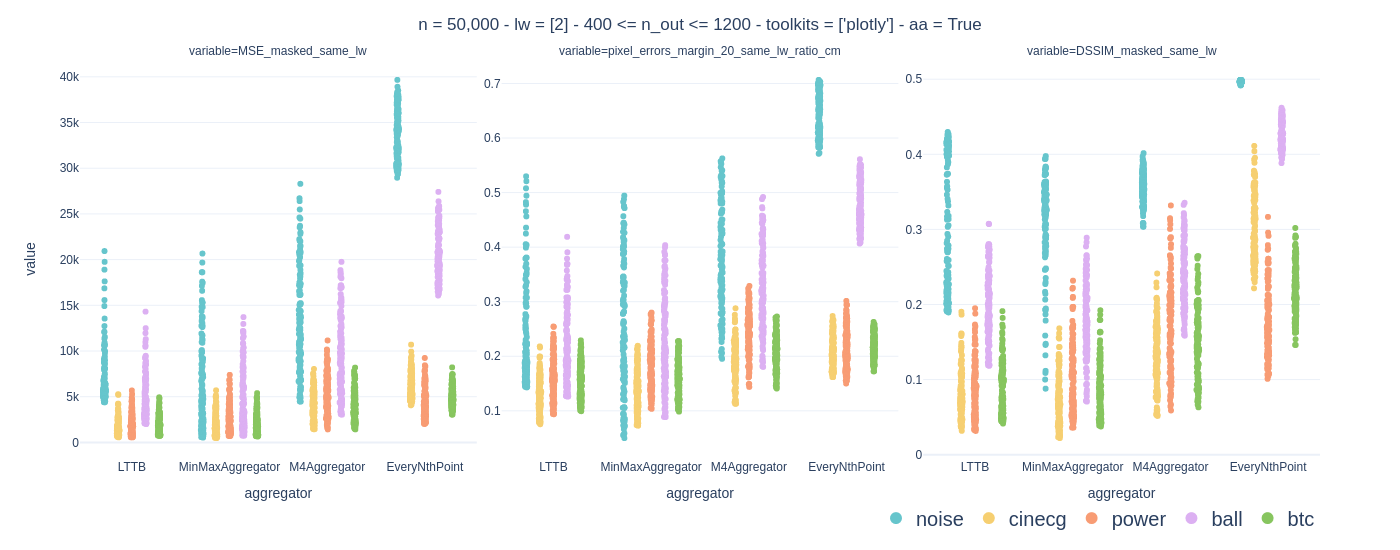

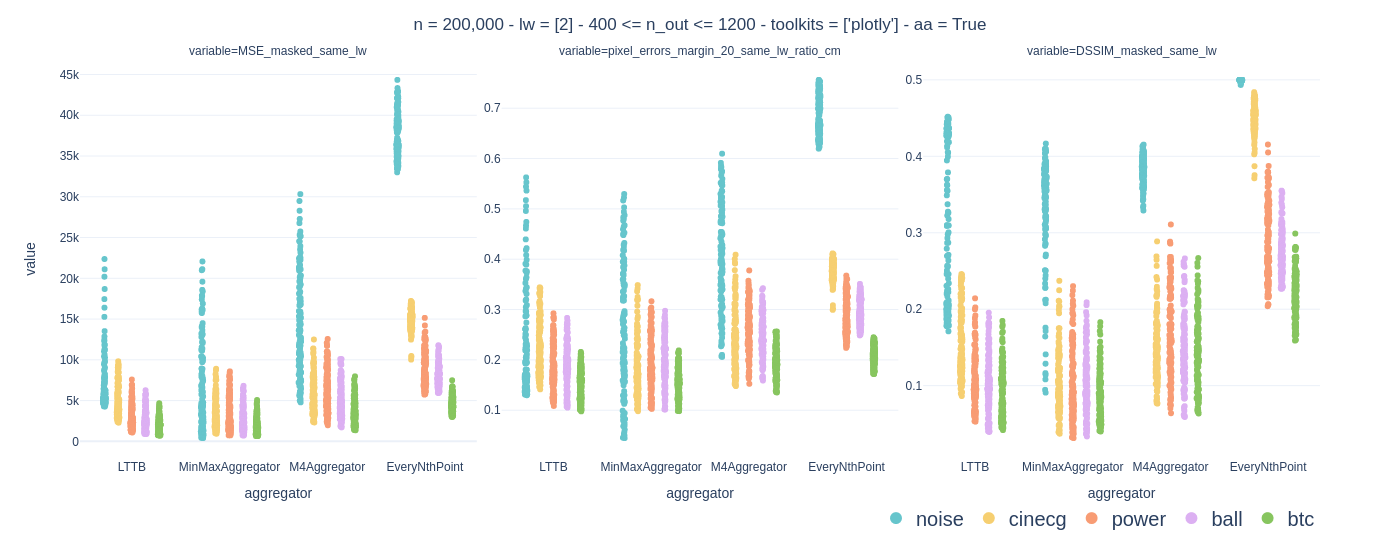

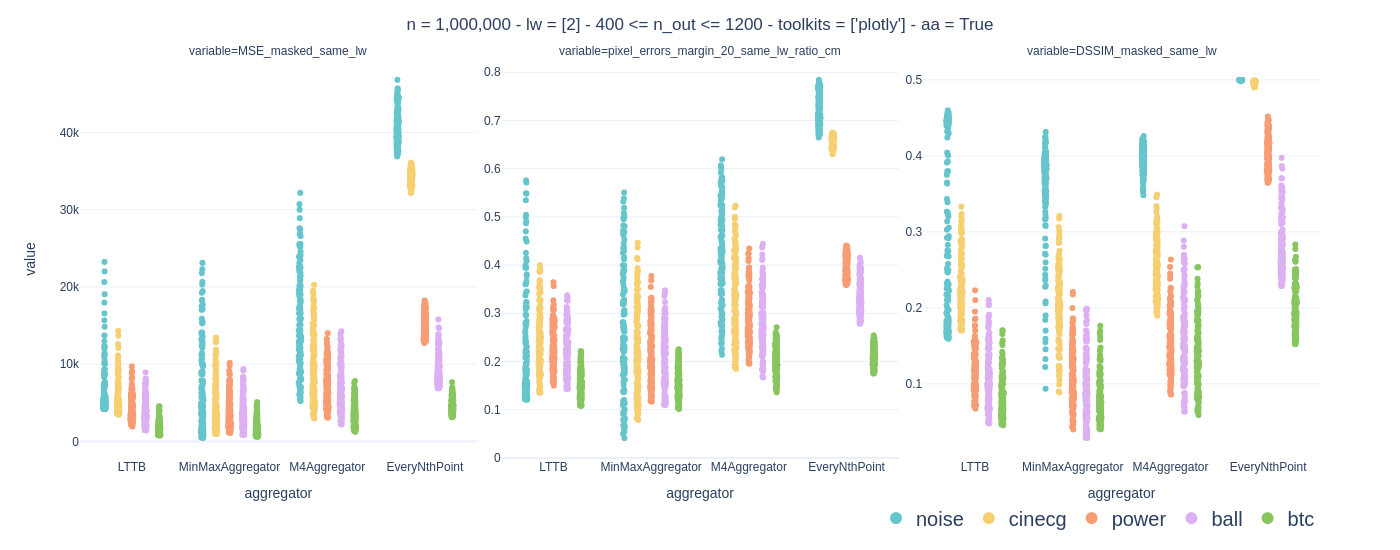

In [103]:
# dataset as color
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
line_widths = [2]
n_out_min, n_out_max = 400, 1200
aa = True
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
for n in [50_000, 200_000, 1_000_000]:
    fig = px.strip(
        df_m_tot[
            (df_m_tot.line_width.isin(line_widths))
            & (df_m_tot.toolkit.isin(toolkits))
            & (df_m_tot.data.isin(["cinecg", "noise", "power", "ball", "btc"]))
            & (df_m_tot.aggregator.isin(aggregators))
            & (df_m_tot.aa == aa)
            & (df_m_tot.n_out <= n_out_max)
            & (df_m_tot.n_out >= n_out_min)
            & (df_m_tot.n == n)
        ].melt(
            id_vars=list(set(df_m_tot.columns).difference(metrics)), value_vars=metrics
        ),
        x="aggregator",
        # color="aggregator",
        y="value",
        # facet_row="data",
        color="data",
        facet_col="variable",
        color_discrete_sequence=list(px.colors.qualitative.Pastel),
        category_orders={
            "data": ["noise", 'cinecg', "power", "ball", "btc"],
            "aggregator": aggregators,
        },
    )

    fig.update_yaxes(matches=None, showticklabels=True)
    fig.update_layout(
        height=600,
        title=f"n = {n:,} - lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
        title_x=0.5,
        template="plotly_white",
        legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            y=-0.20,
            xanchor="right",
            itemsizing="constant",
            x=1,
            font_size=20,
        ),
    ).show(renderer="png", width=1400, height=550)


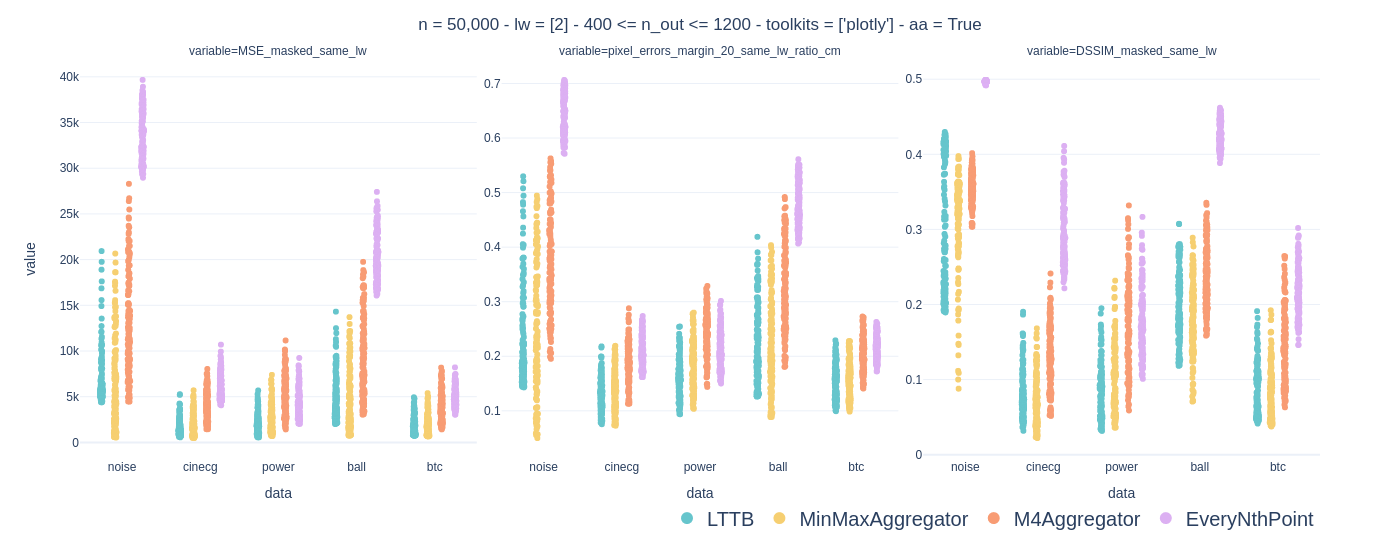

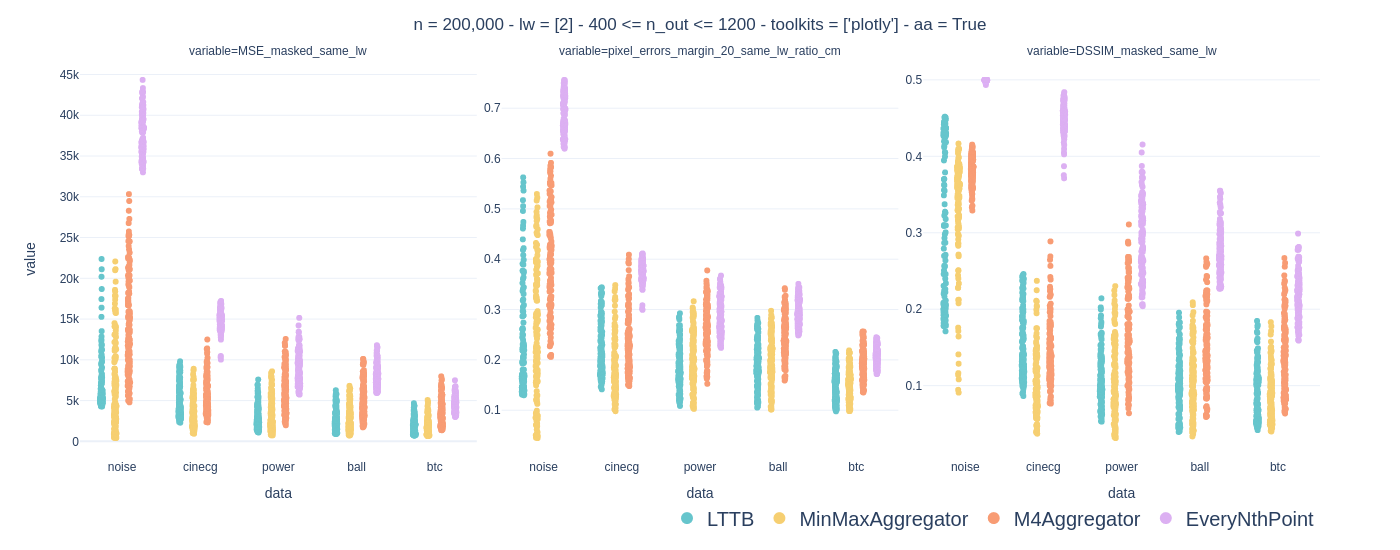

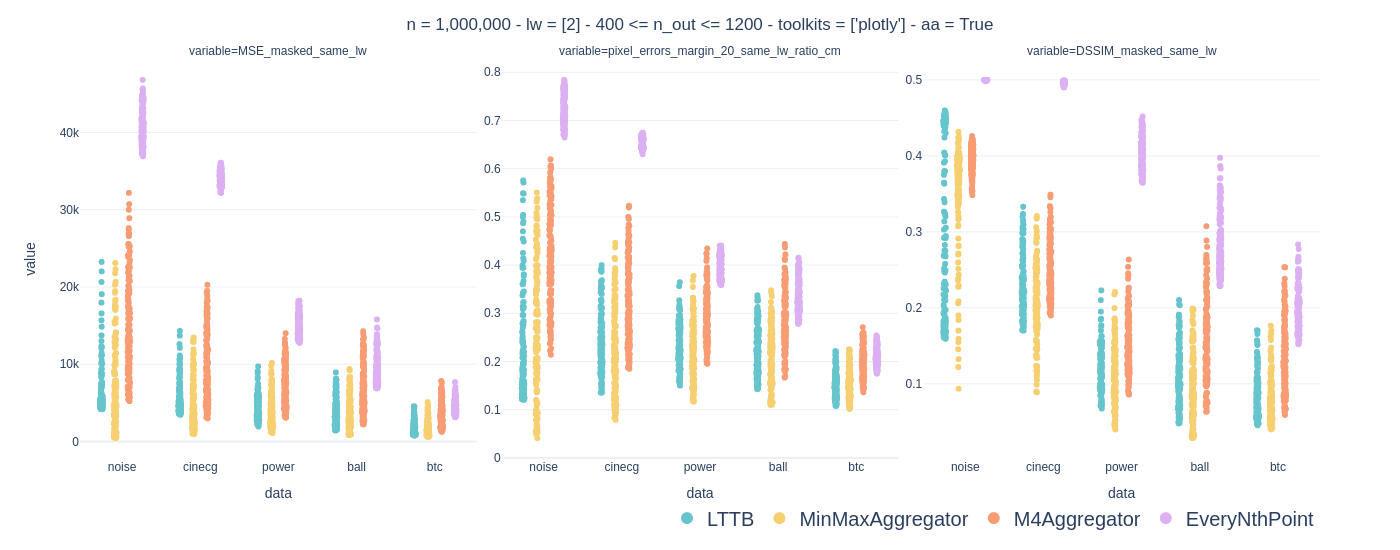

In [105]:
# aggregato as color
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
line_widths = [2]
n_out_min, n_out_max = 400, 1200
aa = True
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
for n in [50_000, 200_000, 1_000_000]:
    fig = px.strip(
        df_m_tot[
            (df_m_tot.line_width.isin(line_widths))
            & (df_m_tot.toolkit.isin(toolkits))
            & (df_m_tot.data.isin(["cinecg", "noise", "power", "ball", "btc"]))
            & (df_m_tot.aggregator.isin(aggregators))
            & (df_m_tot.aa == aa)
            & (df_m_tot.n_out <= n_out_max)
            & (df_m_tot.n_out >= n_out_min)
            & (df_m_tot.n == n)
        ].melt(
            id_vars=list(set(df_m_tot.columns).difference(metrics)), value_vars=metrics
        ),
        x="data",
        y="value",
        color="aggregator",
        facet_col="variable",
        color_discrete_sequence=list(px.colors.qualitative.Pastel),
        category_orders={
            "data": ["noise", 'cinecg', "power", "ball", "btc"],
            "aggregator": aggregators,
        },
    )

    fig.update_yaxes(matches=None, showticklabels=True)
    fig.update_layout(
        height=600,
        title=f"n = {n:,} - lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
        title_x=0.5,
        template="plotly_white",
        legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            y=-0.20,
            xanchor="right",
            itemsizing="constant",
            x=1,
            font_size=20,
        ),
    ).show(renderer="png", width=1400, height=550)


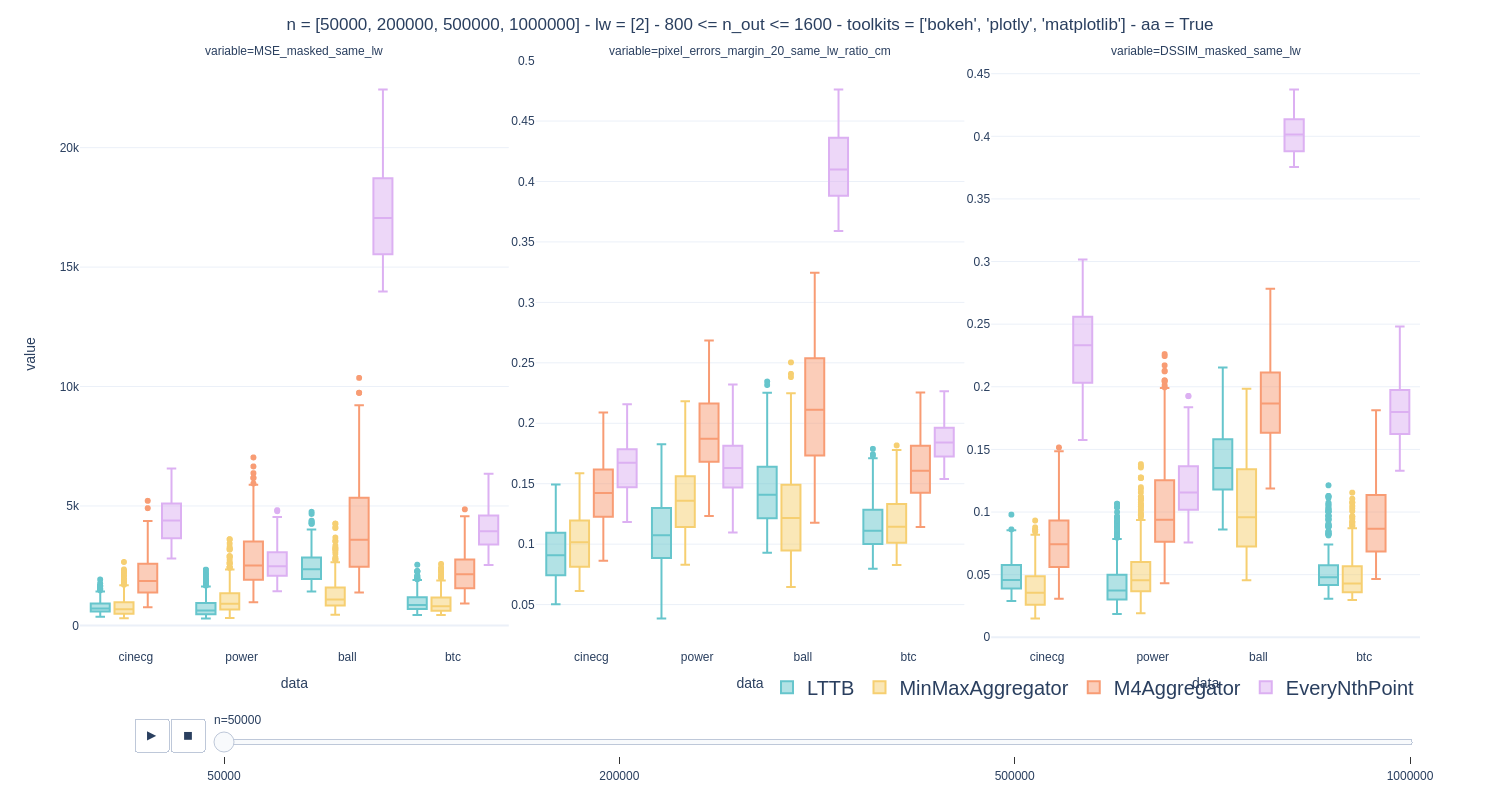

In [82]:
# Aggregator as color
# toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][:-1]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
data_list = [
    "cinecg",
    # "noise",
    "power",
    "ball",
    "btc",
]
aggregators = [
    "LTTB",
    "MinMaxAggregator",
    "M4Aggregator",
    "EveryNthPoint",
]
line_widths = [1, 2][1:2]
n_out_min, n_out_max = 800, 1600
aa = True
ns = [50_000, 200_000, 500_000, 1_000_000]

fig = px.box(
    df_m_tot[
        (df_m_tot.line_width.isin(line_widths))
        & (df_m_tot.toolkit.isin(toolkits))
        & (df_m_tot.data.isin(data_list))
        & (df_m_tot.aggregator.isin(aggregators))
        & (df_m_tot.aa == aa)
        & (df_m_tot.n_out <= n_out_max)
        & (df_m_tot.n_out >= n_out_min)
        # & (df_m_tot.n.isin(ns))
    ].melt(id_vars=list(set(df_m_tot.columns).difference(metrics)), value_vars=metrics),
    x="data",
    y="value",
    color="aggregator",
    animation_frame="n",
    # facet_row="n",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    facet_col="variable",
    category_orders={"data": data_list, "aggregator": aggregators, "n": ns},
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(
    height=400,
    title=f"n = {ns} - lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
    title_x=0.5,
    template="plotly_white",
    boxgroupgap=0.2,
    boxgap=0.1,
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=-0.1,
        xanchor="right",
        x=1,
        font_size=20,
    ),
).show(renderer="png", width=1500, height=800)


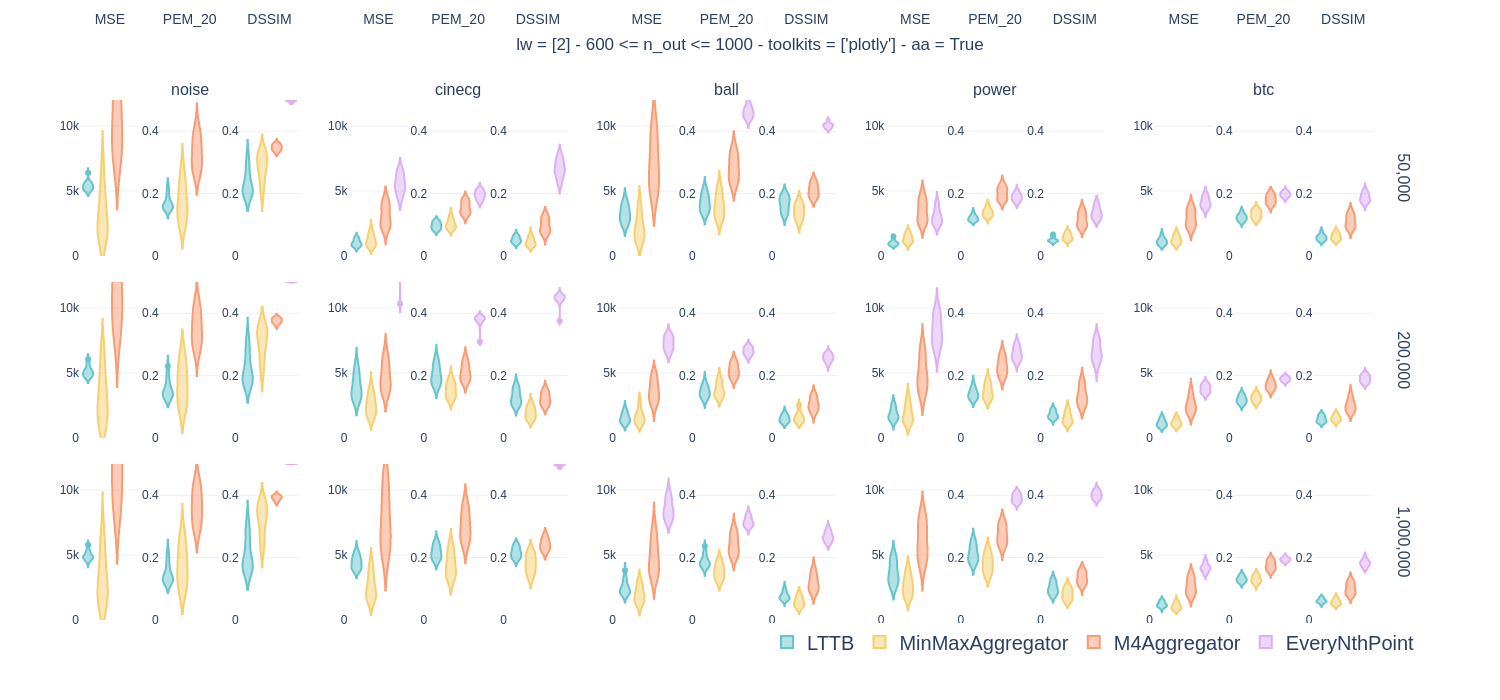

In [89]:
# Box / violin - Aggregator as color
df_vis = df_m_tot.copy()
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
data_list = [
    "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
]
aggregators = ["LTTB", "MinMaxAggregator", "M4Aggregator", "EveryNthPoint"]
line_widths = [1, 2][1:]
n_out_min, n_out_max = 600, 1000
aa = True
ns = [ 50_000, 200_000, 1_000_000]
line_shape = "default"

df_vis = df_vis[
    (df_vis.line_width.isin(line_widths))
    & (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.aa == aa)
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
]
# df_vis[metrics[-1]] /= df_vis[metrics[-1]].max()

column_widths = [1, 1, 1, 0.15] * len(data_list)
column_widths[-1] = 0
fig = make_subplots(
    cols=(len(metrics) + 1) * len(data_list),
    rows=len(ns),
    # shared_yaxes="columns",
    shared_xaxes=False,
    vertical_spacing=0.05,
    horizontal_spacing=0.015,
    row_titles=[f"{n:,}" for n in ns],
    column_widths=column_widths,
    column_titles=list(
        itertools.chain(*[["", data_str, "", ""] for data_str in data_list])
    ),
)

for row_idx, n in enumerate(ns, 1):
    for col_idx, data in enumerate(data_list, 1):
        slc = df_vis[(df_vis.n == n) & (df_vis.data == data)]
        for sub_col_idx, metric in enumerate(metrics, 1):
            for i, aggregator in enumerate(aggregators):
                fig.add_trace(
                    go.Violin(
                        width=0.7,
                        y=slc[slc.aggregator == aggregator][metric],
                        marker_color=px.colors.qualitative.Pastel[i],
                        name=aggregator,
                        showlegend=(col_idx == 1)
                        and (row_idx == 1)
                        and (sub_col_idx == 1),
                    ),
                    row=row_idx,
                    col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                )

fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

for i in range(len(data_list)):
    offset = i * (len(metrics) + 1)
    fig.update_xaxes(title_text="MSE", col=1 + offset, row=len(ns))
    fig.update_xaxes(title_text="PEM_20", col=2 + offset, row=len(ns))
    fig.update_xaxes(title_text="DSSIM", col=3 + offset, row=len(ns))

for i in range(len(data_list)):
    offset = i * (len(metrics) + 1)
    fig.update_yaxes(range=[0, 12000], col=1 + offset)
    fig.update_yaxes(range=[0.00, 0.5], col=2 + offset)
    fig.update_yaxes(range=[0.00, 0.5], col=3 + offset)

fig.update_layout(
    height=1800,
    title=f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=-0.08,
        xanchor="right",
        x=1,
        font_size=20,
    ),
).show(renderer="png", width=1500, height=700)


### `n_out` trend curves

In [91]:
from agg_utils.path_conf import dataset_dir

btc_series = pd.read_parquet(dataset_dir / "btc_high.parquet").set_index("date")["high"]
ball_speed_series = pd.read_parquet(dataset_dir / "ball_speed.parquet").set_index("ts")[
    "v"
]
power_series = pd.read_parquet(dataset_dir / "electrical_power.parquet").set_index(
    "ts"
)["mf03"]
cinecg = pd.read_parquet(dataset_dir / "cinecg.parquet")["ECG"]
hf_sine = pd.read_parquet(dataset_dir / "hf_sine.parquet")["sine"]
hf_noise = pd.read_parquet(dataset_dir / "hf_noise.parquet")["noise"]

data_dict = {
    "noise": hf_noise,
    "cinecg": cinecg,
    "ball": ball_speed_series.iloc[50_000:],
    "power": power_series,
    "btc": btc_series,
}


lw = [2] - 200 <= n_out <= 1999 - toolkits = ['plotly'] - aa = True


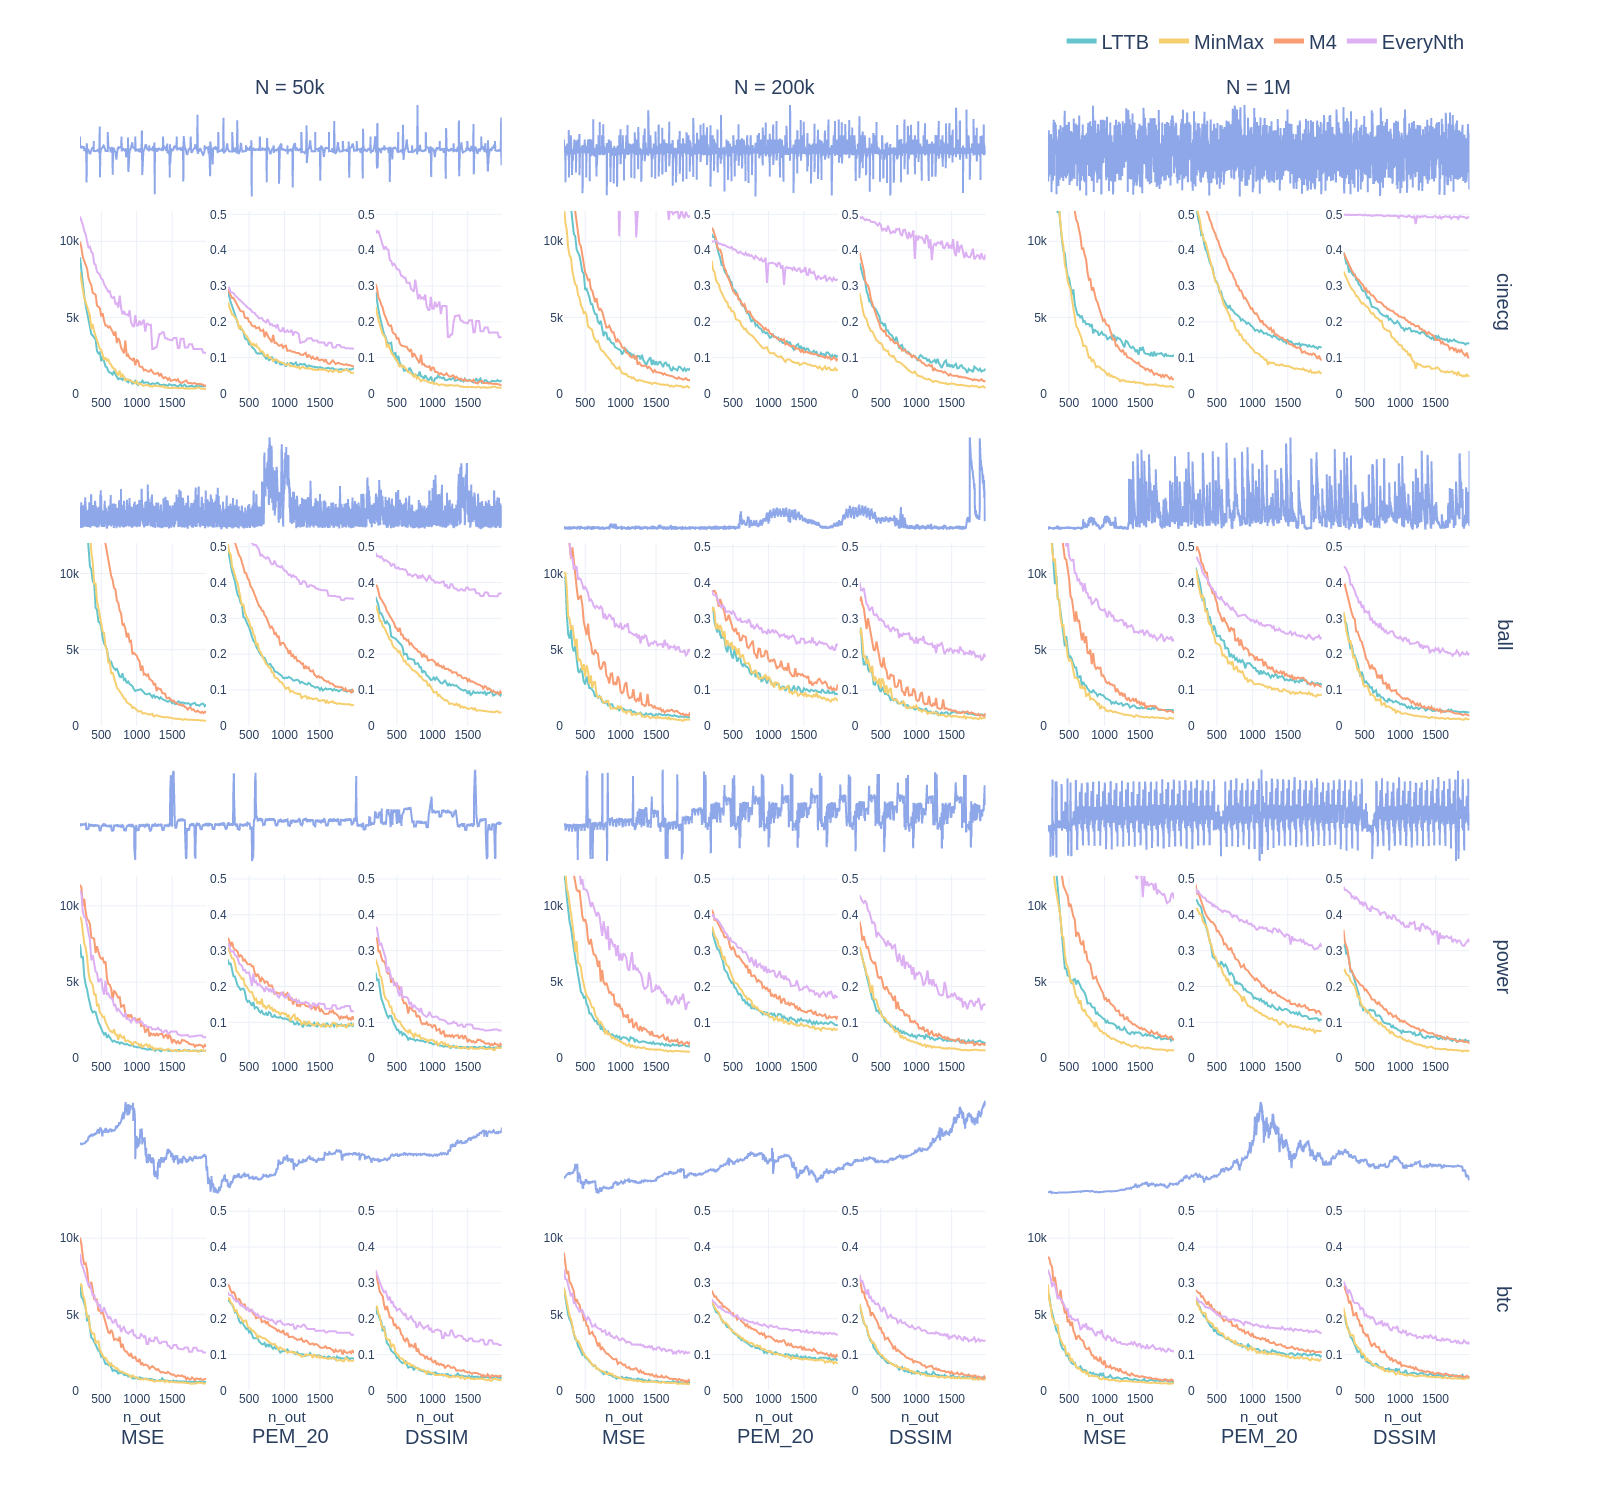

In [92]:
# line - Aggregator as color + also images  - column - n
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
data_list = [
    # "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
][:]
aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "default"
line_widths = [1, 2, 3][1:2]
n_out_min, n_out_max = 200, 1999
aa = True
ns = [
    50_000,
    200_000,
    #  500_000,
    1_000_000,
]

df_vis = df_vis[
    (df_vis.line_width.isin(line_widths))
    & (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.aa == aa)
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
]
# df_vis[metrics[-1]] /= df_vis[metrics[-1]].max()

column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)


for col_idx, n in enumerate(ns, 1):
    for row_idx, data in enumerate(data_list, 1):
        # add the data to the figure
        s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 3000)
        fig.add_trace(
            go.Scatter(
                showlegend=False,
                # line_color="#bfbff2",
                # line_color='#B2A4FF',
                line_color="#8EA7E9",
                # line_color="#aaaaee",
                x=s_agg.index,
                # line_width=,
                y=s_agg,
            ),
            row=3 * (row_idx - 1) + 1,
            col=(col_idx - 1) * (len(metrics) + 1) + 1,
        )
        # print(f"{data} - row = {row_idx} - col = {col_idx}")
        # print(f"row grid: {2 * ( row_idx -1) + 1}  col grid: {(col_idx - 1) * (len(metrics) + 1) + 1}")

        slc = df_vis[(df_vis.n == n) & (df_vis.data == data)].sort_values(by="n_out")
        for sub_col_idx, metric in enumerate(metrics, 1):
            for i, aggregator in enumerate(aggregators):
                # print((col_idx - 1) * len(metrics) + sub_col_idx)
                fig.add_trace(
                    # go.Box(
                    go.Scatter(
                        # go.Violin(
                        # width=.7,
                        y=slc[slc.aggregator == aggregator][metric],
                        x=slc[slc.aggregator == aggregator]["n_out"],
                        # x=[metric] * len(slc[slc.aggregator == aggregator]),
                        marker_color=px.colors.qualitative.Pastel[i],
                        name=aggregator,
                        showlegend=(col_idx == 1)
                        and (row_idx == 1)
                        and (sub_col_idx == 1),
                    ),
                    row=3 * row_idx - 1,
                    col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                )

fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

for i in range(len(data_list)):
    fig.update_yaxes(showticklabels=False, showgrid=False, row=3 * i + 1)


n_cols = len(metrics) * len(ns)
y_metric = -0.023
y_n_out = -0.005
for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
    # also update the font size
    fig.add_annotation(
        text="MSE",
        font_size=font_size,
        xref="paper",
        yref="paper",
        x=mse_x,
        y=y_metric,
        showarrow=False,
    )
for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
    # also update the font size
    fig.add_annotation(
        text="PEM_20",
        font_size=font_size,
        xref="paper",
        yref="paper",
        x=pem_x,
        y=y_metric,
        showarrow=False,
    )
for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
    # also update the font size
    fig.add_annotation(
        text="DSSIM",
        font_size=font_size,
        xref="paper",
        yref="paper",
        x=dssim_x,
        y=y_metric,
        showarrow=False,
    )
for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
    fig.add_annotation(
        text="n_out",
        font_size=font_size - 5,
        xref="paper",
        yref="paper",
        x=n_out_x / n_cols,
        y=y_n_out,
        # align="center",
        showarrow=False,
    )


for row_idx in range(1, len(data_list) + 1):
    fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)


for i in range(len(ns)):
    offset = i * (len(metrics) + 1)
    for row_idx in range(1, len(data_list) + 1):
        fig.update_yaxes(range=[0, 12000], col=1 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=3 + offset, row=row_idx * 3 - 1)
        # if row_idx != len(data_list):
        #     fig.update_xaxes(title_text='n_out', col=1 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=2 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=3 + offset, row=row_idx * 3)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}"
)
fig.update_layout(
    height=1400,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1600, height=1500)

# fig.write_html("paper_vis_rev.html")


## Frames

lw = [1, 2, 3] - 400 <= n_out <= 1999 - toolkits = ['plotly'] - aa = True


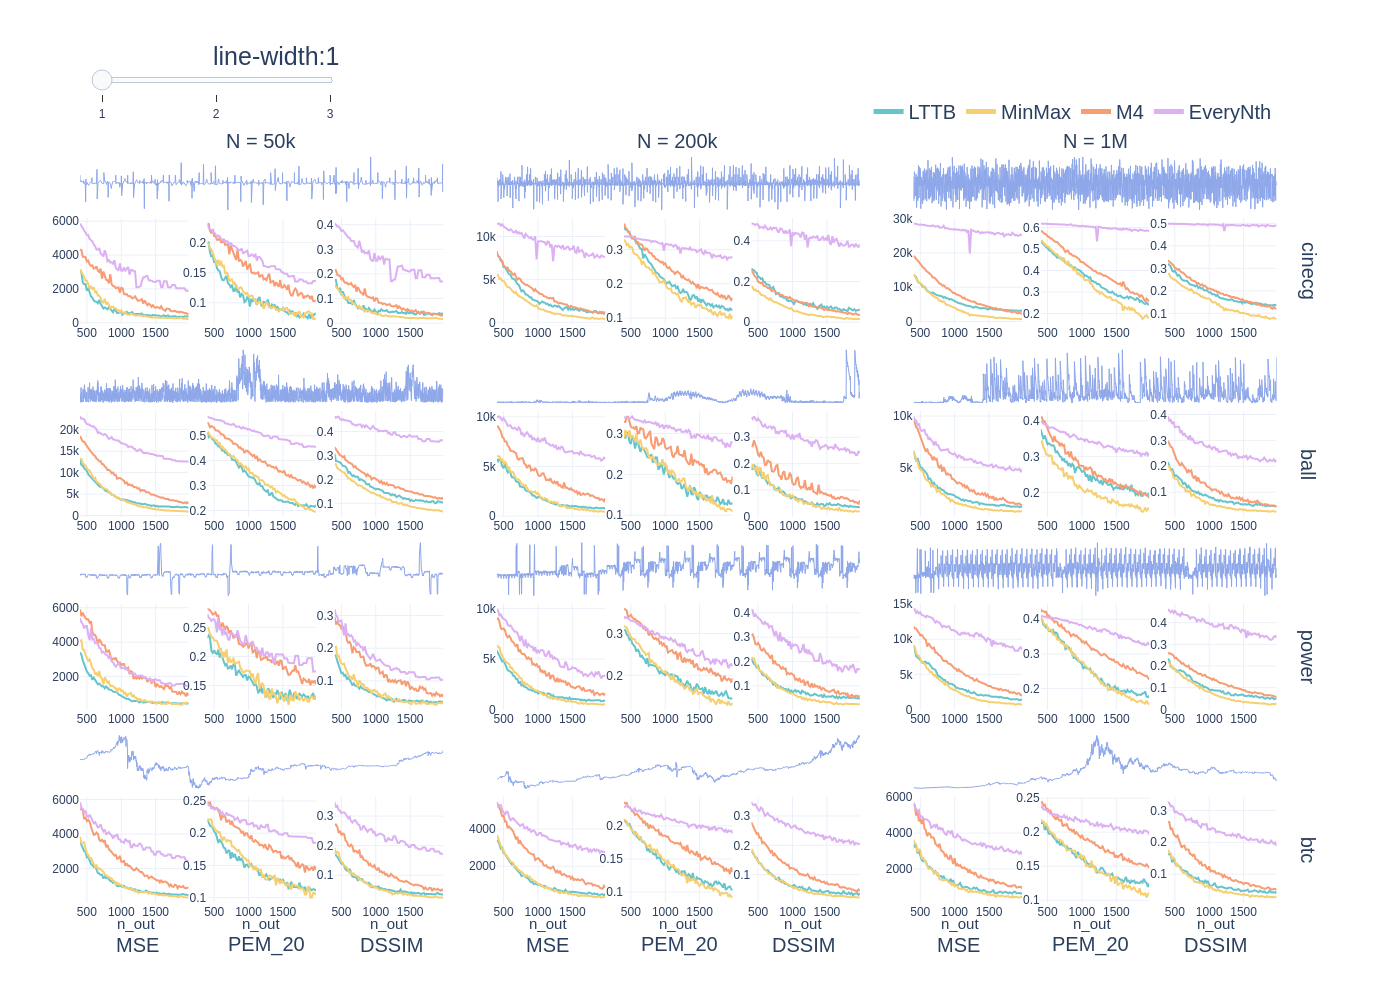

In [93]:
# Animation frame - Line width
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
data_list = ["cinecg", "ball", "power", "btc"]
aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "default"
n_out_min, n_out_max = 400, 1999
aa = True
ns = [50_000, 200_000, 1_000_000]
line_widths = [1, 2, 3, 4][:3]


df_vis = df_vis[
    (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.aa == aa)
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
]

column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)


sliders_dict = {
    "active": 0,
    "yanchor": "bottom",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": font_size + 5},
        "prefix": "line-width:",
        "visible": True,
        "xanchor": "right",
    },
    "transition": {"duration": 800, "easing": "cubic-in-out"},
    "len": 0.2,
    "x": 0.01,
    "y": 1.05,
    "steps": [],
}
for lw in line_widths:
    fig_frame = make_subplots(
        cols=(len(metrics) + 1) * len(ns),
        rows=len(data_list) * 3,
        shared_yaxes=False,
        shared_xaxes=False,
        vertical_spacing=0.007,
        horizontal_spacing=0.015,
        column_titles=list(
            itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
        ),
        column_widths=column_widths,
        row_heights=[0.5, 0.9, 0.1] * len(data_list),
        row_titles=list(
            itertools.chain(*[["", data_str, ""] for data_str in data_list])
        ),
        specs=specs,
    )
    fig_frame.layout = fig.layout

    frame = {"data": [], "name": str(lw)}
    df_vis_tk = df_vis[df_vis.line_width == lw]
    for col_idx, n in enumerate(ns, 1):
        for row_idx, data in enumerate(data_list, 1):
            # add the reference data to the figure
            s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 2500)
            fig_frame.add_trace(
                go.Scatter(
                    showlegend=False,
                    line_color="#8EA7E9",
                    x=s_agg.index,
                    line_width=lw,
                    y=s_agg,
                ),
                row=3 * (row_idx - 1) + 1,
                col=(col_idx - 1) * (len(metrics) + 1) + 1,
            )

            slc = df_vis_tk[(df_vis_tk.n == n) & (df_vis_tk.data == data)].sort_values(
                by="n_out"
            )
            # add the metrics to the figure
            for sub_col_idx, metric in enumerate(metrics, 1):
                for i, aggregator in enumerate(aggregators):
                    fig_frame.add_trace(
                        go.Scatter(
                            y=slc[slc.aggregator == aggregator][metric],
                            x=slc[slc.aggregator == aggregator]["n_out"],
                            marker_color=px.colors.qualitative.Pastel[i],
                            name=aggregator,
                            legendgroup=aggregator,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )
    if lw == line_widths[0]:
        fig.update(data=list(fig_frame.data))

    frame["data"] = list(fig_frame.data)
    frame["traces"] = list(np.arange(len(fig_frame.data)))
    fig["frames"] += (frame,)

    slider_step = {
        "args": [
            [str(lw)],
            {
                "frame": {"duration": 600, "redraw": False},
                "mode": "immediate",  # TODO: what does this mean?
                "transition": {"duration": 600},
            },
        ],
        "label": str(lw),
        "method": "animate",
    }
    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

# --- TODO
if True:
    n_cols = len(metrics) * len(ns)
    y_metric = -0.05
    y_n_out = -0.018
    for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="MSE",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=mse_x,
            y=y_metric,
            showarrow=False,
        )
    for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="PEM_20",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=pem_x,
            y=y_metric,
            showarrow=False,
        )
    for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="DSSIM",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=dssim_x,
            y=y_metric,
            showarrow=False,
        )
    for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
        fig.add_annotation(
            text="n_out",
            font_size=font_size - 5,
            xref="paper",
            yref="paper",
            x=n_out_x / n_cols,
            y=y_n_out,
            # align="center",
            showarrow=False,
        )

    for i in range(len(data_list)):
        fig.update_yaxes(showticklabels=False, showgrid=False, row=3 * i + 1)

    for row_idx in range(1, len(data_list) + 1):
        fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)

    for i in range(len(ns)):
        offset = i * (len(metrics) + 1)
        for row_idx in range(1, len(data_list) + 1):
            fig.update_yaxes(range=[0, 12000], col=1 + offset, row=row_idx * 3)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
)
fig.update_layout(
    height=1000,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1400, height=1000)
fig.write_html("frame_line_width.html")


lw = [2] - 400 <= n_out <= 1999 - toolkits = ['matplotlib', 'matplotlib_cairo'] - aa = False


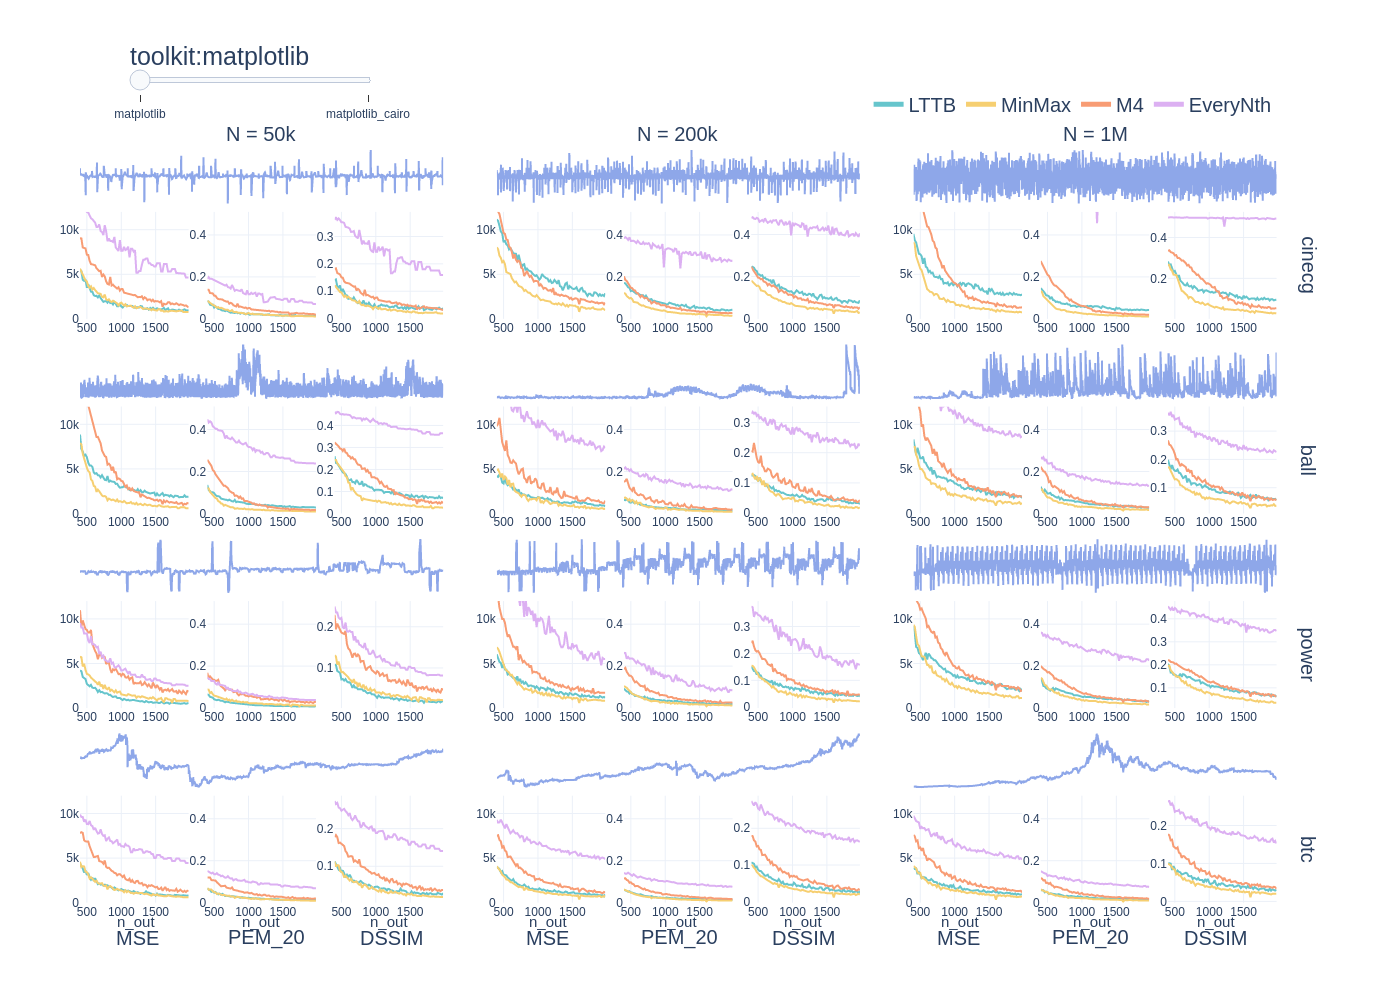

In [94]:
# Animation frame - Toolkits
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][-2:]
data_list = ["cinecg", "ball", "power", "btc"]
aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "default"
n_out_min, n_out_max = 400, 1999
aa = False
ns = [50_000, 200_000, 1_000_000]
line_widths = [1, 2, 3, 4][1:2]


df_vis = df_vis[
    (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.aa == aa)
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
    & (df_vis.line_width.isin(line_widths))
]

column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)


sliders_dict = {
    "active": 0,
    "yanchor": "bottom",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": font_size + 5},
        "prefix": "toolkit:",
        "visible": True,
        "xanchor": "left",
    },
    "transition": {"duration": 800, "easing": "cubic-in-out"},
    "len": 0.2,
    "x": 0.04,
    "y": 1.04,
    "steps": [],
}
for toolkit in toolkits:
    fig_frame = make_subplots(
        cols=(len(metrics) + 1) * len(ns),
        rows=len(data_list) * 3,
        shared_yaxes=False,
        shared_xaxes=False,
        vertical_spacing=0.007,
        horizontal_spacing=0.015,
        column_titles=list(
            itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
        ),
        column_widths=column_widths,
        row_heights=[0.5, 0.9, 0.1] * len(data_list),
        row_titles=list(
            itertools.chain(*[["", data_str, ""] for data_str in data_list])
        ),
        specs=specs,
    )
    fig_frame.layout = fig.layout

    frame = {"data": [], "name": str(toolkit)}
    df_vis_tk = df_vis[df_vis.toolkit == toolkit]
    for col_idx, n in enumerate(ns, 1):
        for row_idx, data in enumerate(data_list, 1):
            s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 2500)
            fig_frame.add_trace(
                go.Scatter(
                    showlegend=False,
                    line_color="#8EA7E9",
                    x=s_agg.index,
                    line_width=line_widths[0],
                    y=s_agg,
                ),
                row=3 * (row_idx - 1) + 1,
                col=(col_idx - 1) * (len(metrics) + 1) + 1,
            )

            slc = df_vis_tk[(df_vis_tk.n == n) & (df_vis_tk.data == data)].sort_values(
                by="n_out"
            )
            # add the metrics to the figure
            for sub_col_idx, metric in enumerate(metrics, 1):
                for i, aggregator in enumerate(aggregators):
                    fig_frame.add_trace(
                        go.Scatter(
                            y=slc[slc.aggregator == aggregator][metric],
                            x=slc[slc.aggregator == aggregator]["n_out"],
                            marker_color=px.colors.qualitative.Pastel[i],
                            name=aggregator,
                            legendgroup=aggregator,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )
    if toolkit == toolkits[0]:
        fig.update(data=list(fig_frame.data))

    frame["data"] = list(fig_frame.data)
    frame["traces"] = list(np.arange(len(fig_frame.data)))
    fig["frames"] += (frame,)

    slider_step = {
        "args": [
            [str(toolkit)],
            {
                "frame": {"duration": 600, "redraw": False},
                "mode": "immediate",  # TODO: what does this mean?
                "transition": {"duration": 600},
            },
        ],
        "label": str(toolkit),
        "method": "animate",
    }
    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

# --- TODO
if True:
    n_cols = len(metrics) * len(ns)
    y_metric = -0.04
    y_n_out = -0.015
    for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="MSE",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=mse_x,
            y=y_metric,
            showarrow=False,
        )
    for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="PEM_20",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=pem_x,
            y=y_metric,
            showarrow=False,
        )
    for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="DSSIM",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=dssim_x,
            y=y_metric,
            showarrow=False,
        )
    for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
        fig.add_annotation(
            text="n_out",
            font_size=font_size - 5,
            xref="paper",
            yref="paper",
            x=n_out_x / n_cols,
            y=y_n_out,
            # align="center",
            showarrow=False,
        )
    for row_idx in range(1, len(data_list) + 1):
        fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)
        fig.update_yaxes(showgrid=False, showticklabels=False, row=3 *(row_idx - 1) + 1)

    for i in range(len(ns)):
        offset = i * (len(metrics) + 1)
        for row_idx in range(1, len(data_list) + 1):
            fig.update_yaxes(range=[0, 12000], col=1 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
)
fig.update_layout(
    height=1000,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1400, height=1000)
# fig.write_html("frame_toolkits.html")

lw = [2] - 400 <= n_out <= 1999 - toolkits = ['bokeh_aa=True', 'plotly_aa=True', 'matplotlib_aa=True', 'matplotlib_cairo_aa=True', 'matplotlib_aa=False', 'matplotlib_cairo_aa=False'] - aa = False


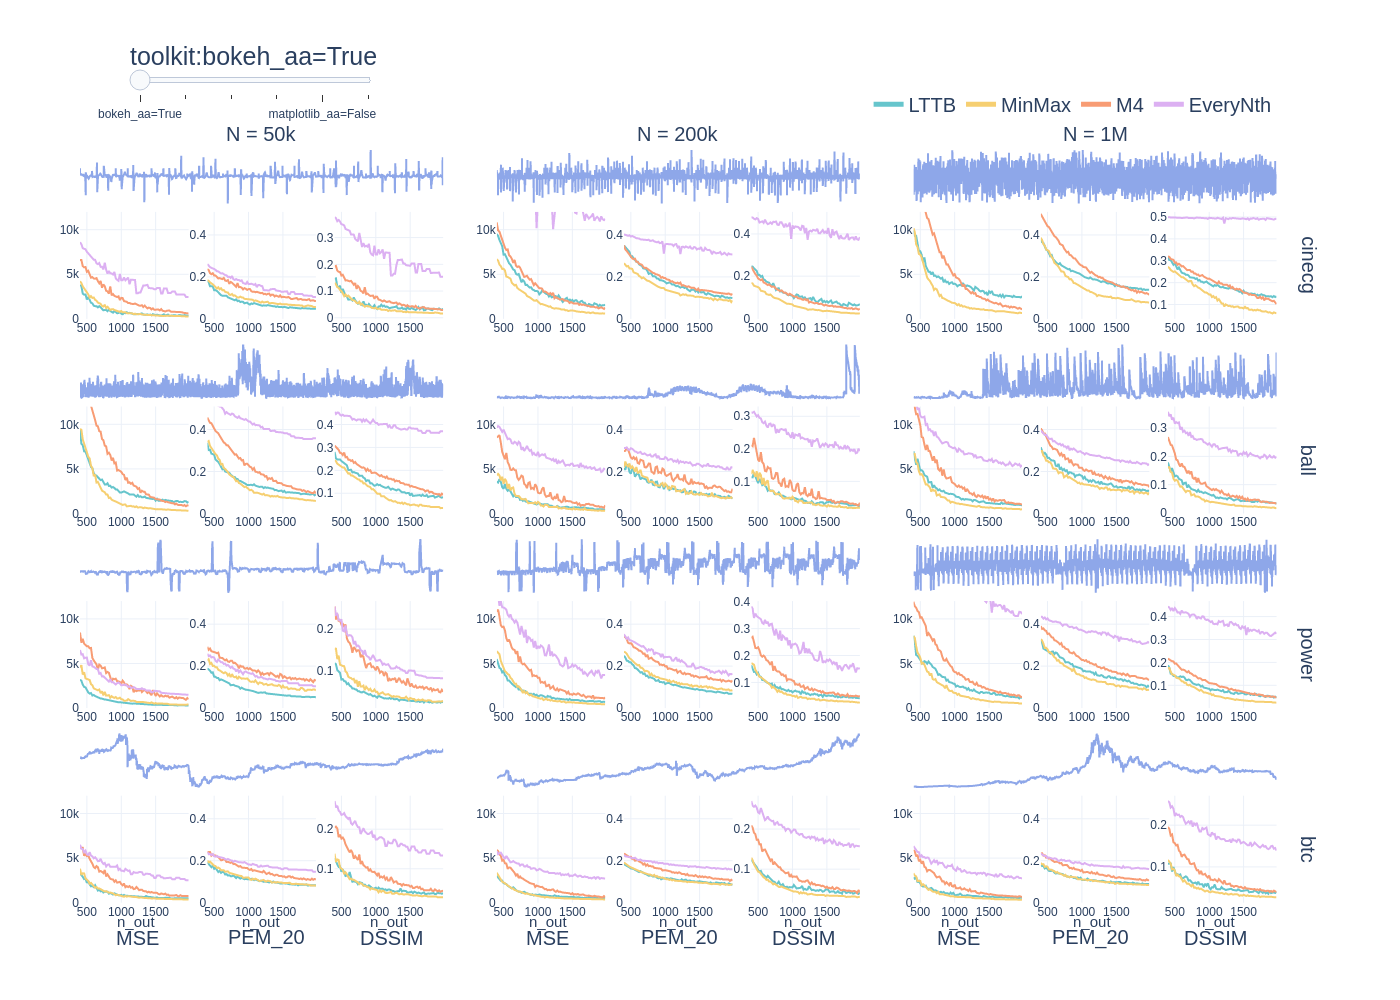

In [95]:
# Animation frame - Toolkits & AA
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

data_list = ["cinecg", "ball", "power", "btc"]
aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
df_vis['toolkit_str'] = df_vis.toolkit.astype('str') + '_aa=' + df_vis.aa.astype('str')
toolkits = ["bokeh_aa=True", "plotly_aa=True", "matplotlib_aa=True", "matplotlib_cairo_aa=True",'matplotlib_aa=False', 'matplotlib_cairo_aa=False']
line_shape = "default"
n_out_min, n_out_max = 400, 1999
aa = False
ns = [50_000, 200_000, 1_000_000]
line_widths = [1, 2, 3, 4][1:2]


df_vis = df_vis[
    (df_vis.toolkit_str.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
    & (df_vis.line_width.isin(line_widths))
]

column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)


sliders_dict = {
    "active": 0,
    "yanchor": "bottom",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": font_size + 5},
        "prefix": "toolkit:",
        "visible": True,
        "xanchor": "left",
    },
    "transition": {"duration": 800, "easing": "cubic-in-out"},
    "len": 0.2,
    "x": 0.04,
    "y": 1.04,
    "steps": [],
}
for toolkit in toolkits:
    fig_frame = make_subplots(
        cols=(len(metrics) + 1) * len(ns),
        rows=len(data_list) * 3,
        shared_yaxes=False,
        shared_xaxes=False,
        vertical_spacing=0.007,
        horizontal_spacing=0.015,
        column_titles=list(
            itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
        ),
        column_widths=column_widths,
        row_heights=[0.5, 0.9, 0.1] * len(data_list),
        row_titles=list(
            itertools.chain(*[["", data_str, ""] for data_str in data_list])
        ),
        specs=specs,
    )
    fig_frame.layout = fig.layout

    frame = {"data": [], "name": str(toolkit)}
    df_vis_tk = df_vis[df_vis.toolkit_str == toolkit]
    for col_idx, n in enumerate(ns, 1):
        for row_idx, data in enumerate(data_list, 1):
            s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 2500)
            fig_frame.add_trace(
                go.Scatter(
                    showlegend=False,
                    line_color="#8EA7E9",
                    x=s_agg.index,
                    line_width=line_widths[0],
                    y=s_agg,
                ),
                row=3 * (row_idx - 1) + 1,
                col=(col_idx - 1) * (len(metrics) + 1) + 1,
            )

            slc = df_vis_tk[(df_vis_tk.n == n) & (df_vis_tk.data == data)].sort_values(
                by="n_out"
            )
            # add the metrics to the figure
            for sub_col_idx, metric in enumerate(metrics, 1):
                for i, aggregator in enumerate(aggregators):
                    fig_frame.add_trace(
                        go.Scatter(
                            y=slc[slc.aggregator == aggregator][metric],
                            x=slc[slc.aggregator == aggregator]["n_out"],
                            marker_color=px.colors.qualitative.Pastel[i],
                            name=aggregator,
                            legendgroup=aggregator,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )
    if toolkit == toolkits[0]:
        fig.update(data=list(fig_frame.data))

    frame["data"] = list(fig_frame.data)
    frame["traces"] = list(np.arange(len(fig_frame.data)))
    fig["frames"] += (frame,)

    slider_step = {
        "args": [
            [str(toolkit)],
            {
                "frame": {"duration": 600, "redraw": False},
                "mode": "immediate",  # TODO: what does this mean?
                "transition": {"duration": 600},
            },
        ],
        "label": str(toolkit),
        "method": "animate",
    }
    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

# --- TODO
if True:
    n_cols = len(metrics) * len(ns)
    y_metric = -0.04
    y_n_out = -0.015
    for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="MSE",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=mse_x,
            y=y_metric,
            showarrow=False,
        )
    for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="PEM_20",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=pem_x,
            y=y_metric,
            showarrow=False,
        )
    for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="DSSIM",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=dssim_x,
            y=y_metric,
            showarrow=False,
        )
    for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
        fig.add_annotation(
            text="n_out",
            font_size=font_size - 5,
            xref="paper",
            yref="paper",
            x=n_out_x / n_cols,
            y=y_n_out,
            # align="center",
            showarrow=False,
        )
    for row_idx in range(1, len(data_list) + 1):
        fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)
        fig.update_yaxes(showgrid=False, showticklabels=False, row=3 *(row_idx - 1) + 1)

    for i in range(len(ns)):
        offset = i * (len(metrics) + 1)
        for row_idx in range(1, len(data_list) + 1):
            fig.update_yaxes(range=[0, 12000], col=1 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
)
fig.update_layout(
    height=1000,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1400, height=1000)
# fig.write_html("frame_toolkits.html")


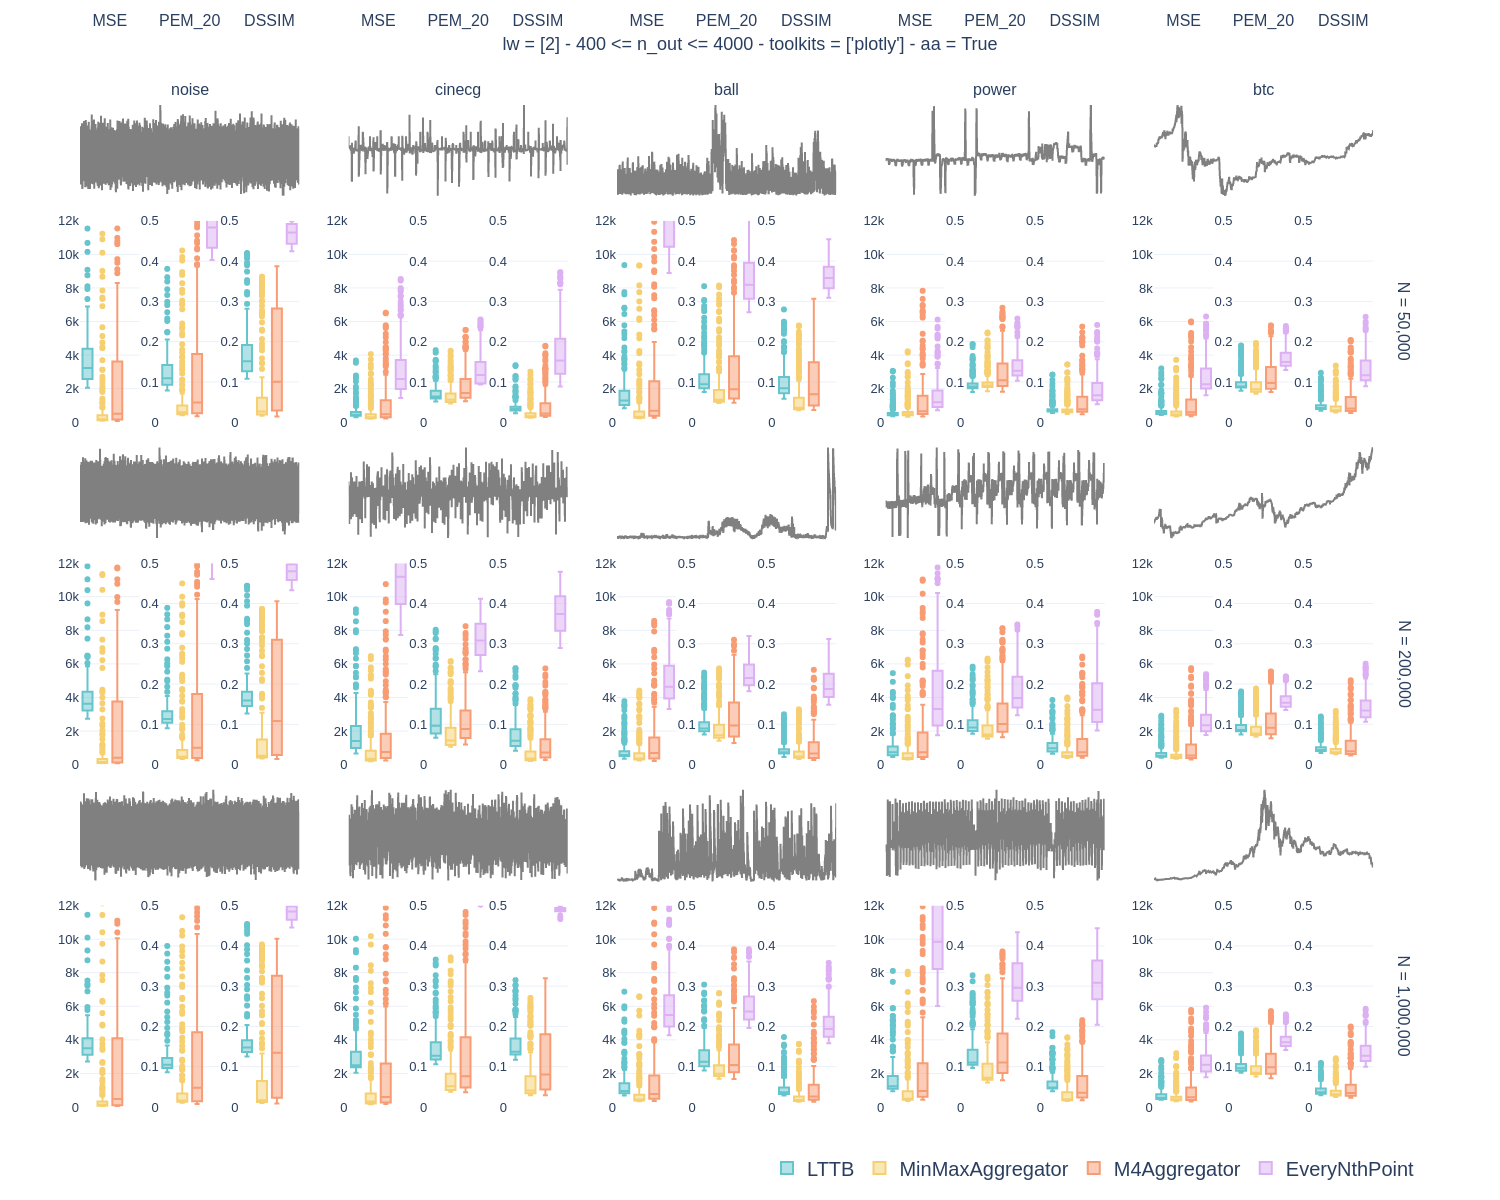

In [101]:
# box - Aggregator as color + also images
df_vis = df_m_tot.copy()
toolkits = ["bokeh", "plotly", "matplotlib", "matplotlib_cairo"][1:2]
data_list = [
    "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
aggregators = ["LTTB", "MinMaxAggregator", "M4Aggregator", "EveryNthPoint"]
line_shape = "default"
line_widths = [1, 2, 3][1:2]
n_out_min, n_out_max = 400, 4000
aa = True
ns = [ 50_000, 200_000, 1_000_000 ]

df_vis = df_vis[
    (df_vis.line_width.isin(line_widths))
    & (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.aa == aa)
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
]
# df_vis[metrics[-1]] /= df_vis[metrics[-1]].max()

column_widths = [1, 1, 1, 0.15] * len(data_list)
column_widths[-1] = 0
specs = []
for i in range(len(ns)):
    specs += [[{"colspan": 3}, None, None, {}] * len(data_list)]
    specs += [[{}] * 4 * len(data_list)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(data_list),
    rows=len(ns) * 2,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.02,
    horizontal_spacing=0.015,
    row_titles=list(itertools.chain(*[["", f"N = {n:,}"] for n in ns])),
    column_widths=column_widths,
    row_heights=[0.5, 1] * len(ns),
    column_titles=list(
        itertools.chain(
            *[
                [
                    data_str,
                    "",
                ]
                for data_str in data_list
            ]
        )
    ),
    specs=specs,
)


for row_idx, n in enumerate(ns, 1):
    for col_idx, data in enumerate(data_list, 1):
        # add the data to the figure
        s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 7000)
        fig.add_trace(
            go.Scatter(
                showlegend=False,
                line_color=highlight_color,
                x=s_agg.index,
                line_width=line_widths[0],
                y=s_agg,
            ),
            row=2 * (row_idx - 1) + 1,
            col=(col_idx - 1) * (len(metrics) + 1) + 1,
        )
        # print(f"{data} - row = {row_idx} - col = {col_idx}")
        # print(f"row grid: {2 * ( row_idx -1) + 1}  col grid: {(col_idx - 1) * (len(metrics) + 1) + 1}")

        slc = df_vis[(df_vis.n == n) & (df_vis.data == data)].sort_values(by="n_out")
        for sub_col_idx, metric in enumerate(metrics, 1):
            for i, aggregator in enumerate(aggregators):
                # print((col_idx - 1) * len(metrics) + sub_col_idx)
                fig.add_trace(
                    go.Box(
                        # go.Scatter(
                        # go.Violin(
                        # width=.7,
                        y=slc[slc.aggregator == aggregator][metric],
                        # x=slc[slc.aggregator == aggregator]["n_out"],
                        # x=[metric] * len(slc[slc.aggregator == aggregator]),
                        marker_color=px.colors.qualitative.Pastel[i],
                        name=aggregator,
                        showlegend=(col_idx == 1)
                        and (row_idx == 1)
                        and (sub_col_idx == 1),
                    ),
                    row=2 * row_idx,
                    col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                )

fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

for i in range(len(ns)):
    fig.update_yaxes(showticklabels=False, showgrid=False, row=2 * i + 1)

for i in range(len(data_list)):
    offset = i * (len(metrics) + 1)
    fig.update_xaxes(title_text="MSE", col=1 + offset, row=2 * len(ns))
    fig.update_xaxes(title_text="PEM_20", col=2 + offset, row=2 * len(ns))
    fig.update_xaxes(title_text="DSSIM", col=3 + offset, row=2 * len(ns))


for i in range(len(data_list)):
    offset = i * (len(metrics) + 1)
    for row_idx in range(1, len(ns) + 1):
        fig.update_yaxes(range=[0, 12000], col=1 + offset, row=row_idx * 2)
        fig.update_yaxes(range=[0.00, 0.5], col=2 + offset, row=row_idx * 2)
        fig.update_yaxes(range=[0.00, 0.5], col=3 + offset, row=row_idx * 2)


fig.update_layout(
    height=1400,
    title=f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - aa = {aa}",
    title_x=0.5,
    template="plotly_white",
    boxgap=0.05,
    # boxmode="group",
    font_size=13,
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=-0.08,
        xanchor="right",
        x=1,
        font_size=20,
    ),
).show(renderer="png", width=1500, height=1200)
